<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 08**
- Daniele Avolio    , ist1111559
- Michele Vitale	, ist1111558	
- Luís Dias	        , ist198557

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

This function takes a document, along with optional inverted index and clustering arguments, and returns the best clustering solution for the given task, determined by proper internal indices.

In [1]:
# Imports useful later

import os
import sys
import time
import random
import nltk
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import cluster 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings



In [2]:
import os  


def read_files(location:str, skip_first_line:bool=True) -> list:
    """
    Read all text files in the specified location and return their contents as a list.
    """
    files_list = []
    
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".txt"): 
                with open(os.path.join(root, file), "r") as auto:
                    if skip_first_line: auto.readline()
                    # Skip the first line
                    files_list.append(auto.read().strip())
    return files_list

In [3]:

categories_ranges = {
    'business': [0, 509],
    'entertainment': [510, 895],
    'politics': [896, 1311],
    'sport': [1312, 1823],
    'tech': [1824, 2224]
}

We will get those from the beginning, so we won't have problems in the future.

In [4]:
documents = read_files("../BBC News Summary/News Articles")
summaries = read_files("../BBC News Summary/Summaries", skip_first_line=False)

In [5]:
print(documents[0])
print()
print(summaries[0])


Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-spe

In [6]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import math



def sentence_clustering(d: str, I=None, alpha=1, beta=0.45, gamma=0.05, **kwargs):
    # Workflow idea:
    # 1. Split the document into sentences using nltk
    # 2. Convert the sentences into vectors using TfIdf
    # 3. Cluster the vectors using Hierarchical Clustering
    # 4. Return the clusters

    # Problems: How many clusters should we use?
    # Answer: We can use the elbow method to find the optimal number of clusters

    # Problems: How do we know if the clusters are good?
    # Answer: We can use the silhouette score to evaluate the quality of the clusters

    sentences = nltk.sent_tokenize(d)

    word_sentenes = [nltk.word_tokenize(sentence) for sentence in sentences]

    # remove words sentences with less than 10 words
    words_sentences = [s for s in word_sentenes if len(s) > 5]
    
    # Join sequences again
    sentences = [" ".join(s) for s in words_sentences]

    # Remove all sentences of len 1
    # (Time 23:14 - Wasted estimated time: 2h)
    # Problem: Literally a dot '.'
    sentences = [s for s in sentences if len(s) > 1]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Parameter for the score functoin
    # Best number of clusters
    best_score = 0
    best_n_clusters = 2

    max_clusters = kwargs.get("max_clusters", len(sentences))

    if max_clusters > len(sentences):
        max_clusters = len(sentences)

    linkage = kwargs.get("linkage", "complete")
    metric = "cosine"

    if linkage == "ward":
        metric = "euclidean"

    
    for n_clusters in range(2, max_clusters):
        model = AgglomerativeClustering(
            n_clusters=n_clusters, linkage=linkage, metric=metric
        )
        labels = model.fit_predict(X.toarray())
        # Calculate the silhouette score, which measures the compactness and separation of the clusters.
        # A higher silhouette score indicates better clustering quality.
        # It ranges from -1 to 1, with 1 being the best score.
        # The goal is to maximize the silhouette score.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

        silhouette_score_value = silhouette_score(X.toarray(), labels) * alpha

        # # Calculate the Calinski-Harabasz score, which measures the ratio of between-cluster dispersion to within-cluster dispersion.
        # # A higher Calinski-Harabasz score indicates better clustering quality.
        # # It is based on the analysis of variance (ANOVA) and measures the separation between clusters.
        # # The goal is to maximize the Calinski-Harabasz score.
        # # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html
        # c_score = calinski_harabasz_score(X.toarray(), labels) * beta

        # # clusters score based on the number of clusters
        # # the more, the worse. We are going to subtract this value from the final score

        # cluster_score = math.log(n_clusters)
        # final_score = math.log(silhouette_score_value) + math.log(c_score) - cluster_score * gamma
        # print(f"Numero di cluster: {n_clusters}, Silhouette score: {silhouette_score_value}, Calinski-Harabasz score: {c_score}, Final score: {final_score}")

        if silhouette_score_value > best_score:
            best_score = silhouette_score_value
            best_n_clusters = n_clusters

    # print(f"Numero ottimale di cluster: {best_n_clusters}")

    model = AgglomerativeClustering(
        n_clusters=best_n_clusters, linkage=linkage, metric=metric
    )

    labels = model.fit_predict(X.toarray())

    # 5. Costruisci la soluzione di clustering
    cluster_solution = {}
    for i, label in enumerate(labels):
        if label not in cluster_solution:
            cluster_solution[label] = []
        cluster_solution[label].append(sentences[i])

    if kwargs.get("return_centroids", False):
        ncentroid = NearestCentroid()
        ncentroid.fit(X.toarray(), labels)
        centroids = ncentroid.centroids_
        return cluster_solution, centroids

    return cluster_solution

In [7]:
doc = documents[0]
sentence_clustering(doc, None, linkage="ward")

{3: ['Quarterly profits at US media giant TimeWarner jumped 76 % to $ 1.13bn ( Â£600m ) for the three months to December , from $ 639m year-earlier .',
  'But its film division saw profits slump 27 % to $ 284m , helped by box-office flops Alexander and Catwoman , a sharp contrast to year-earlier , when the third and final film in the Lord of the Rings trilogy boosted results .',
  'For the full-year , TimeWarner posted a profit of $ 3.36bn , up 27 % from its 2003 performance , while revenues grew 6.4 % to $ 42.09bn .'],
 4: ['The firm , which is now one of the biggest investors in Google , benefited from sales of high-speed internet connections and higher advert sales .',
  'TimeWarner said fourth quarter sales rose 2 % to $ 11.1bn from $ 10.9bn .'],
 1: ['Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros , and less users for AOL .',
  'For 2005 , TimeWarner is projecting operating earnings growth of around 5 % , and also expects higher revenue and wider

We will create a functio to visualize the clusters.

In [129]:

from sklearn.decomposition import PCA

def plot_clusters(clusters:dict, return_plot:bool=False, **kwargs):
    # Get the vector space from the clusters
    values = clusters.values()

    # Convert the sentences into vectors using TfIdf
    vectorizer = TfidfVectorizer(stop_words="english")
    sentences = [sentence for cluster in values for sentence in cluster]
    
    X = vectorizer.fit_transform(sentences)

    

    # Reduce the dimensionality of the vectors to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    if kwargs.get("summary", False):
        # Get the summary
        summary = kwargs.get("summary")
        summary = nltk.sent_tokenize(summary)

        # Convert the summary into vectors using TfIdf
        summary = vectorizer.transform(summary)

        # Reduce the dimensionality of the vectors to 2D
        summary_pca = pca.transform(summary.toarray())
    

    # Plot the clusters and set the color 
    # knowing that the keys of the clusters are the labels and the 
    # values are the sentences

    for key, value in clusters.items():
        plt.scatter(X_pca[[sentences.index(sentence) for sentence in value], 0], 
                    X_pca[[sentences.index(sentence) for sentence in value], 1], 
                    label=f"Cluster {key}", s=151)  # Set the size of the circles to 100

    #if we have summarypca plot in the graph with black borders for each sentence in the summary
    if kwargs.get("summary", False):
        plt.scatter(summary_pca[:, 0], summary_pca[:, 1], color="yellow", edgecolors="black", s=151,label="Summary")
        
    if return_plot: return plt
    
    # Plot the confidence ellipses
    plt.legend()
    plt.show()




In [10]:
for i, doc in enumerate(documents):
    clusters = sentence_clustering(doc)

The way we are selecting the best clustering solution is by using the silhouette score, which is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Other than that we are using the Calinski-Harabasz index, which is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.

The number of cluster is determined usign minimum 2 or maximum the number of sentences in the document. Not sure if this is the best approach, but we will see.

Documento 0


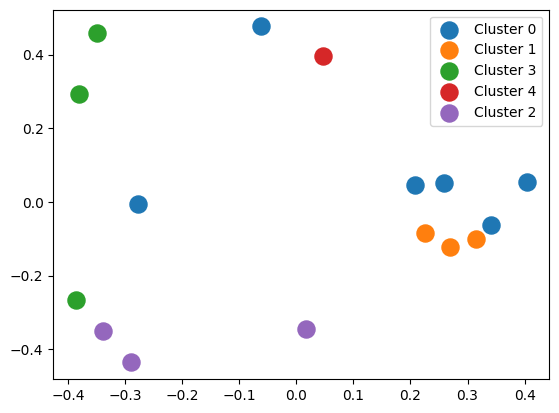



Documento 1


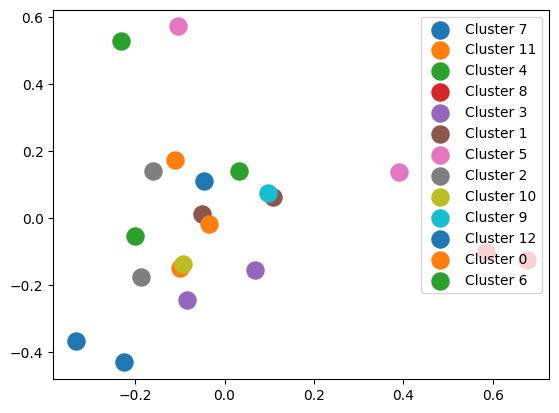



Documento 2


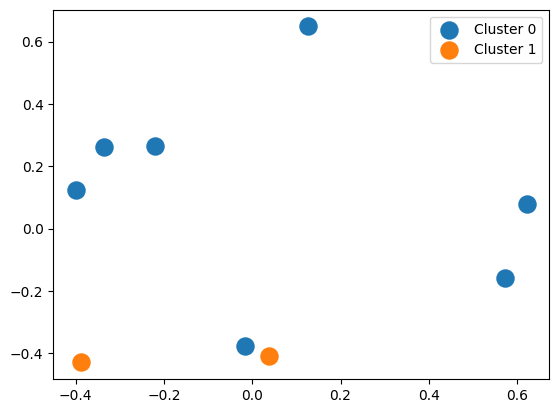



Documento 3


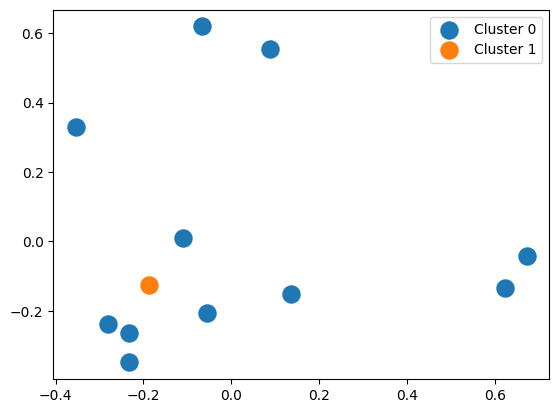



Documento 4


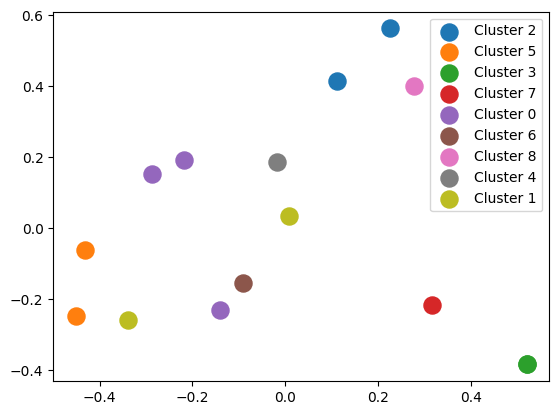



Documento 5


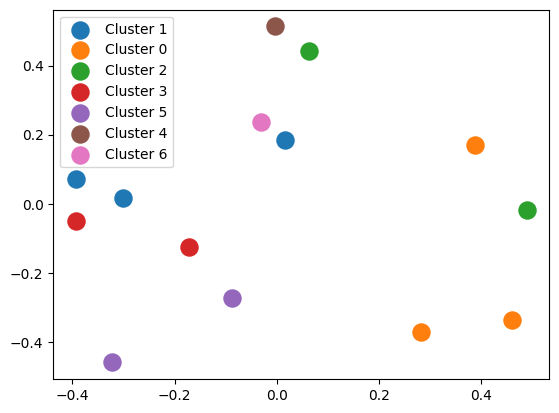



Documento 6


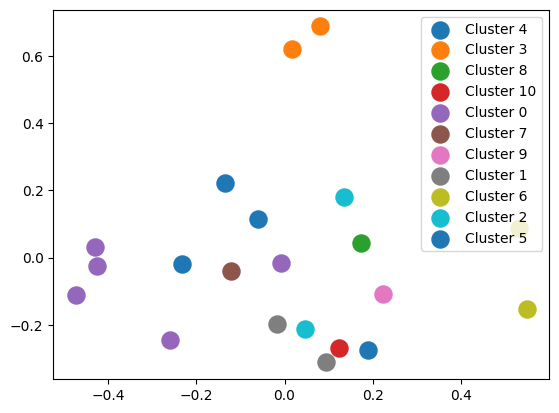



Documento 7


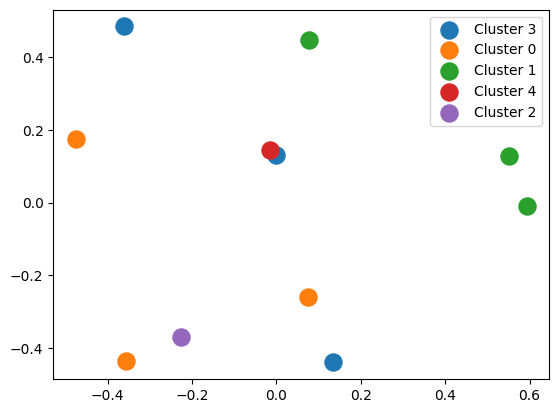



Documento 8


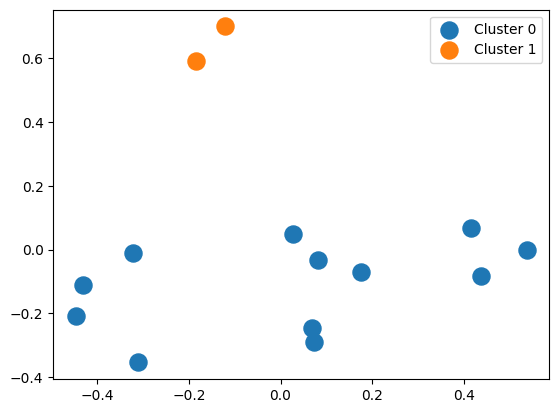



Documento 9


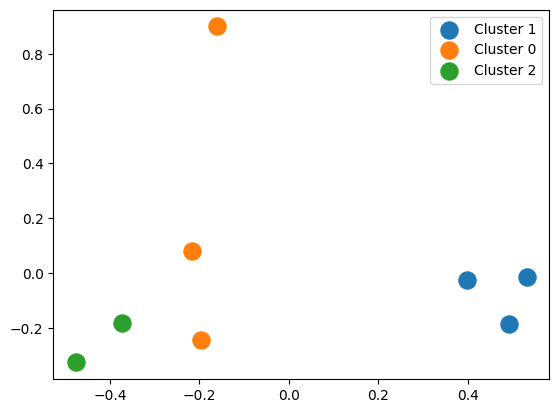

In [11]:
docs = documents[50:60]
for i, doc in enumerate(docs):
    print(f"Documento {i}")
    clusters = sentence_clustering(doc)
    plot_clusters(clusters)
    print("\n")

*B) Summarization*

In [12]:
# Summarizatio part
from sklearn.metrics.pairwise import cosine_similarity

def summarization(doc:str, clusters:dict, I=None, centroids=None, **kwargs):
    number_of_sentences = kwargs.get("number_of_sentences", 1)

    sentences = nltk.sent_tokenize(doc)

    # Convert each sentene in array of words s
    word_sentenes = [nltk.word_tokenize(sentence) for sentence in sentences]

    # remove words sentences with less than 10 words
    words_sentences = [s for s in word_sentenes if len(s) > 5]
    
    # Join sequences again
    sentences = [" ".join(s) for s in words_sentences]

    # Remove all sentences of len 1
    # (Time 23:14 - Wasted estimated time: 2h)
    # Problem: Literally a dot '.'
    sentences = [s for s in sentences if len(s) > 1]


    
    # We keep 1 at the beginning to see how it goes
    final_summary = ""        
    vectorizer = TfidfVectorizer()

    # We fit the vectorizer with all the sentences in the document
    vectorizer.fit(sentences)


    # For each cluster
    for k in clusters.keys():
        # We take the phrases
        phrases = clusters[k]
        distances = []

        # We transform the phrases into vectors using tfidf
        X = vectorizer.transform(phrases)

        centroid = centroids[k]

        # For each phrase vector
        for phrase in X.toarray():
            distances.append(cosine_similarity(phrase.reshape(1, -1), centroid.reshape(1, -1)))


        # Sort the sentences by their distance to the centroid
        sorted_indices = np.argsort(distances, axis=0).flatten()

        # Add the top sentences to the final summary
        final_summary += " ".join([phrases[i] for i in sorted_indices[:number_of_sentences]])

    # print(f"\n - Number of clusters: {len(clusters.keys())} \n - Number of sentences per cluster: {number_of_sentences} \n - Summary: {final_summary}")
    return final_summary

In [13]:
# Try with doc 0
doc = documents[43]

clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=2)

print(summary)

A recession is commonly defined as two consecutive quarters of negative growth , although the Japanese government takes other factors into account when judging the status of its economy . On Wednesday , the government revised growth figures from earlier in 2004 which , when taking into account performance in the most recent period , effectively tips Japan into recession .A previous estimate of 0.1 % growth between July and September was downgraded to a 0.3 % decline . Ministers pointed to the fact that consumer spending had been depressed by one-off factors such as the unseasonably mild winter .The Tokyo stock market fell after the figures were announced , but rose again on a widespread perception that the economy will recover later this year . Analysts said the figures were disappointing but argued that Japan 's largest companies had been recording healthy profits and capital spending was on the rise .However , politicians remain upbeat about prospects for an economic boost later in t

In [16]:
# Let's test the time to summarize all the documents
import time

start = time.time()

for i,doc in enumerate(documents):

    clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
    summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=2)

end = time.time()

print(f"Time to summarize all the documents: {end - start} seconds")
print(f"Average time per document: {(end - start) / len(documents)} seconds")

Time to summarize all the documents: 68.3044376373291 seconds
Average time per document: 0.030698623657226563 seconds


*C) Keyword extraction*

In [17]:


def keyword_extraction(doc:str, C:dict, I=None, **kwargs):
    # doc words

    words = nltk.word_tokenize(doc)

    # Stopwords
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Punctuation
    words = [word for word in words if word.isalpha()]
    # Digits
    words = [word for word in words if not word.isdigit()]

    # In this case we need lemmatization
    lemmatizer = nltk.WordNetLemmatizer()

    words = [lemmatizer.lemmatize(word) for word in words]


    cluster_keywords = []

    # Vectorizer
    # For each cluster
    for k in C.keys():
        keywords = []
        phrases = C[k]
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(phrases)
        
        # For each keyword get the tfidf score
        for word in set(words):
            if word in vectorizer.vocabulary_:
                tfidf = X.toarray()[:, vectorizer.vocabulary_[word]]
                keywords.append((word, np.mean(tfidf)))
        
        # Sort the keywords by their tfidf score
        keywords = sorted(keywords, key=lambda x: x[1], reverse=True)

        
        cluster_keywords.append(keywords[:3])


    keywords = []
    # take only the first element of the pair
    for k in cluster_keywords:
        for word, _ in k:
            keywords.append(word)
    
    return list(set(keywords))

In [18]:
doc = documents[0]
clusters = sentence_clustering(doc)

keyword_extraction(doc, clusters, None)

['greatly',
 'chief',
 'rose',
 'posted',
 'growth',
 'loss',
 'review',
 'resolve',
 'internet',
 'earnings',
 'profit',
 'mixed',
 'exceptional',
 'pay',
 'executive',
 'said',
 'grew',
 'inquiry',
 'restate',
 'business',
 'set',
 'stake',
 'film',
 'book',
 'owns',
 'better',
 'fourth',
 'quarter']

In [20]:
# Extraction test over all the documents

start = time.time()


extractions = {}
for i, doc in enumerate(documents):
    clusters = sentence_clustering(doc)
    keywords = keyword_extraction(doc, clusters, None)
    category = None
    for k, v in categories_ranges.items():
        if v[0] <= i <= v[1]:
            category = k
            break

    extractions[i] = {
        "index" : i,
        "keywords": keywords,
        "category": category
    }

end = time.time()

print(f"Time to extract keywords from all the documents: {end - start} seconds")
print(f"Average time per document: {(end - start) / len(documents)} seconds")
# We will use this to build our dataset

Time to extract keywords from all the documents: 126.74396204948425 seconds
Average time per document: 0.05696357844920641 seconds


*D) Evaluation*

In [73]:
# Using the project 1 evaluation functions

import nltk
def precision(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    if len(summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(summary_words)

def recall(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    if len(relevant_summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(relevant_summary_words)

def accuracy(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))
    retrieved = len(summary_words)

    if len(relevant_summary_words) == 0:
        return 0
    
    return retrieved_and_relevant / retrieved

# Lecture
def f1_score(precision, recall, alpha=0.5):
    if precision == 0 or recall == 0:
        return 0
    
    return 1 / (alpha / precision + (1 - alpha) / recall)

# Lab
def alternative_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    
    return 2 * (precision * recall) / (precision + recall)

# Net
def mean_average_precision(precision_list, recall_list):
    # Sort by recall
    sorted_indices = np.argsort(recall_list)
    sorted_precision = np.array(precision_list)[sorted_indices]
    sorted_recall = np.array(recall_list)[sorted_indices]
    
    # Compute the precision envelope
    for i in range(sorted_precision.size - 1, 0, -1):
        sorted_precision[i - 1] = np.maximum(sorted_precision[i - 1], sorted_precision[i])
    
    # Calculate the average precision
    recall_change = np.diff(sorted_recall)
    precision_change = sorted_precision[:-1]
    ap = np.sum(recall_change * precision_change)
    
    return ap

    

In [22]:
from sklearn.metrics import auc


def plot_pr_curve(precision, recall, name):
    pairs = sorted(zip(recall, precision))

    recall = []
    precision = []
    for pair in pairs:
        recall.append(pair[0])
        precision.append(pair[1])
        
    
    # We will get the best precision at that point
        # and we will do it in reverse 
    precision = list(precision)
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])
    
    
    area = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve for {name} (area = {area:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {name}')
    plt.legend(loc="lower left")
    plt.show()

In [74]:

def evaluation_given_summaries(produced_summaries:list, real_summaries:list, name, plot_roc=True):

    initial_time = time.time()

    # We need to compare the produced summaries with the real summaries
    # evaluation statistics, including F-measuring at predefined p-or-l summary
    # limits, recall-and-precision curves, MAP, and efficiency

    # Calculate precision and recall for each document
    precisions = []
    recalls = []


    for i, key in enumerate(produced_summaries):
        precision_value = precision(produced_summaries[i], real_summaries[i])
        recall_value = recall(produced_summaries[i], real_summaries[i])
        precisions.append(precision_value)
        recalls.append(recall_value)

    
    # Calculate the average precision and recall
    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)

    # Calculate the F1 score
    f1 = alternative_f1_score(average_precision, average_recall)

    # Calculate standard deviation
    std_precision = np.std(precisions)
    std_recall = np.std(recalls)
    
    m_a_p = mean_average_precision(precisions, recalls)

    if plot_roc:
        plot_pr_curve(precisions, recalls, name)


    end_time = time.time() - initial_time

    print()
    print(f"""####### Time to process {len(produced_summaries)} documents: \n 
        - {end_time} seconds \n
        - {end_time / len(produced_summaries)} seconds per document
        \n""")
    print()

    return average_precision, average_recall, f1, std_precision, std_recall, m_a_p

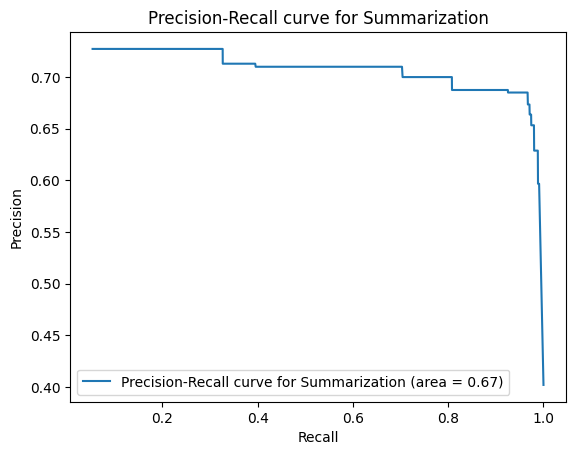


####### Time to process 2225 documents: 
 
        - 14.808773040771484 seconds 

        - 0.006655628332931004 seconds per document
        


Average precision: 0.47142565623110294
Average recall: 0.7145305336995985
F1 score: 0.5680614994153812
Standard deviation of precision: 0.0820834016611938
Standard deviation of recall: 0.22476602113157132
Mean average precision: 0.6696701998831003


In [24]:
docs_to_summarize = documents
real_summaries = summaries

produced_summaries = []

for i, doc in enumerate(docs_to_summarize):
    clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
    summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=5)
    produced_summaries.append(summary)

average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(produced_summaries, real_summaries, "Summarization")

print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"F1 score: {f1}")
print(f"Standard deviation of precision: {std_precision}")
print(f"Standard deviation of recall: {std_recall}")
print(f"Mean average precision: {m_a_p}")

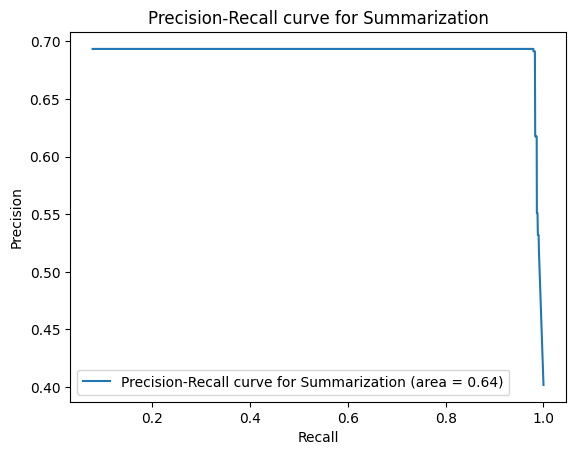


####### Time to process 2225 documents: 
 
        - 12.111963748931885 seconds 

        - 0.005443579213003094 seconds per document
        


Average precision: 0.4799297359171955
Average recall: 0.816188954041604
F1 score: 0.6044405534869197
Standard deviation of precision: 0.07050204099776335
Standard deviation of recall: 0.18694984477568183


In [25]:
# Let's try to change the number of sentences to summarize and max clusters
docs_to_summarize = documents
real_summaries = summaries

produced_summaries = []

for i, doc in enumerate(docs_to_summarize):
    clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=4)
    summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=9)
    produced_summaries.append(summary)

average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(produced_summaries, real_summaries, "Summarization")

print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"F1 score: {f1}")
print(f"Standard deviation of precision: {std_precision}")
print(f"Standard deviation of recall: {std_recall}")



<h3>Part II: classification</h3>

### The challenge here

The challenge is to build a nice `features` set for the sentences.

The goal is the following: *Take a sentence and a groundh truth summary. If the sentence is in the summary, the target variable will be $1$, otherwise $0$.*

The features will be used to `train` a model, and then `predict` the sentences that are in the summary.

- Number of words
- Number of stopwords
- Number of keywords
- General length of the sentence
- TF-IDF Score
- BM25 Score
- Cosine Similarity
- Position of the sentence in the document
- Category

*A) Feature extraction*

In [26]:
def get_similarity(sentence: str, doc: str):
    vectorizer = TfidfVectorizer()

    vectorizer.fit_transform(nltk.sent_tokenize(doc))

    sentence_vector = vectorizer.transform([sentence])
    doc_vector = vectorizer.transform([doc])

    similarity = cosine_similarity(sentence_vector, doc_vector).flatten()

    return similarity[0]

In [27]:
def feature_extraction(sentence: str, doc: str, doc_index=None, **kwargs):
    # cosine similarity between doc and sentence
    doc_tokenized = nltk.sent_tokenize(doc)
    words = nltk.word_tokenize(sentence)
    similarity = get_similarity(sentence, doc)

    # Numerical
    n_sentence = len(doc_tokenized)
    n_words = len(words)
    n_stopwords = len([word for word in words if word in ENGLISH_STOP_WORDS])

    if doc_index is None:
        n_keywords = len(keyword_extraction(doc, sentence_clustering(doc)))
    else:
        n_keywords = len(
            [word for word in words if word in extractions[doc_index]["keywords"]]
        )
    length_of_sentence = len(sentence)

    # TFIDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(doc_tokenized)
    sentence_vector = vectorizer.transform([sentence])
    tfidf_score = np.mean(sentence_vector.toarray())

    position_in_doc = doc_tokenized.index(sentence)

    if doc_index is None:
        category = "New"
    else:
        category = extractions[doc_index]["category"]

    # Tags
    pos_tags = nltk.pos_tag(words)
    n_nouns = len(
        [word for word, pos in pos_tags if pos in ["NN", "NNS", "NNP", "NNPS"]]
    )
    n_verbs = len(
        [
            word
            for word, pos in pos_tags
            if pos in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
        ]
    )
    n_adjectives = len([word for word, pos in pos_tags if pos in ["JJ", "JJR", "JJS"]])
    n_adverbs = len([word for word, pos in pos_tags if pos in ["RB", "RBR", "RBS"]])

    return [
        similarity,
        n_sentence,
        n_words,
        n_stopwords,
        n_keywords,
        length_of_sentence,
        tfidf_score,
        position_in_doc,
        category,
        n_nouns,
        n_verbs,
        n_adjectives,
        n_adverbs,
    ]

In [28]:
# Create the features list
features_list = []
count = 0
for i, doc in enumerate(documents):
    for sentence in nltk.sent_tokenize(doc):
        features = feature_extraction(sentence, doc, doc_index=i)
        features.append(count)
        if sentence in summaries[i]:
            features.append(1)
        else:
            features.append(0)
        count += 1
        features_list.append(features)

# This is very computationally expensive, so run it only once if the dataset is not created


In [29]:
# Create the dataframe
columns = [
    "similarity",
    "n_sentence",
    "n_words",
    "n_stopwords",
    "n_keywords",
    "length_of_sentence",
    "tfidf_score",
    "position_in_doc",
    "category",
    "n_nouns",
    "n_verbs",
    "n_adjectives",
    "n_adverbs",
    "id",
    "summary",
]

In [30]:
try:
    df = pd.read_csv("dataset.csv")
    exists = True
except:
    df = pd.DataFrame(features_list, columns=columns)

In [31]:
df.head()

,similarity,n_sentence,n_words,n_stopwords,n_keywords,length_of_sentence,tfidf_score,position_in_doc,n_nouns,n_verbs,n_adjectives,n_adverbs,id,summary,category_business,category_entertainment,category_politics,category_sport,category_tech
0,0.359330,20,28,7,0,136,0.019886,0,8,1,3,0,0,1,True,False,False,False,False
1,0.405842,20,26,10,1,143,0.019617,1,8,2,3,1,1,0,True,False,False,False,False
2,0.280236,20,15,2,3,69,0.015022,2,4,2,1,0,2,1,True,False,False,False,False
3,0.332313,20,22,8,1,106,0.019389,3,9,3,1,0,3,1,True,False,False,False,False
4,0.278403,20,15,5,2,71,0.015667,4,5,2,1,1,4,0,True,False,False,False,False


In [32]:
# one hot encoding if we don't have the zip file
if not exists:
    df = pd.get_dummies(df, columns=["category"])

In [33]:
if not exists:
    df.to_csv("dataset.csv", index=False)

*B) Classification*

In [38]:
# Model creation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.drop(columns=["id", "summary"])
y = df["summary"]

# Since we have 5 different categories, our dataset should be balanced.
# We need to extract the 80% and 20% for each of the categories. So, let's do it manually

# take all the documents for each category in the dataset
categories = {
    "business": df[df["category_business"] == 1],
    "entertainment": df[df["category_entertainment"] == 1],
    "politics": df[df["category_politics"] == 1],
    "sport": df[df["category_sport"] == 1],
    "tech": df[df["category_tech"] == 1]
}

# Split the dataset into training and testing
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for category, data in categories.items():
    X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(
        data.drop(columns=["id", "summary"]), data["summary"], test_size=0.2
    )

    X_train = pd.concat([X_train, X_train_category])
    X_test = pd.concat([X_test, X_test_category])
    y_train = pd.concat([y_train, y_train_category])
    y_test = pd.concat([y_test, y_test_category])

In [39]:
y_train.shape, y_test.shape

((33120, 1), (8283, 1))

In [40]:
def plot_models_scores(scores:pd.DataFrame):
    fig, ax = plt.subplots()
    # make a plot for this
    scores.plot(kind="bar", ax=ax)
    ax.set_title("Models scores")
    ax.set_xlabel("Model")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    plt.show()

In [55]:
# Train each model
models = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "GaussianNB": GaussianNB(),
    "KNeighbors": KNeighborsClassifier(),
    "MLP": MLPClassifier(),
}

scores = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1"], index=models.keys())

warnings.filterwarnings("ignore")
for name, model in models.items():
    print(f"Training {name} model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification report: \n {classification_report(y_test, y_pred)}")
    print("\n")
    scores.loc[name] = [accuracy, precision, recall, f1]

Training RandomForest model
Accuracy: 0.7371725220330798
Confusion matrix: 
 [[3931  875]
 [1302 2175]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.75      0.82      0.78      4806
         1.0       0.71      0.63      0.67      3477

    accuracy                           0.74      8283
   macro avg       0.73      0.72      0.72      8283
weighted avg       0.74      0.74      0.73      8283



Training GradientBoosting model
Accuracy: 0.7037305324157914
Confusion matrix: 
 [[3831  975]
 [1479 1998]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      4806
         1.0       0.67      0.57      0.62      3477

    accuracy                           0.70      8283
   macro avg       0.70      0.69      0.69      8283
weighted avg       0.70      0.70      0.70      8283



Training GaussianNB model
Accuracy: 0.610044669805626
Confusion matrix: 
 [[2838

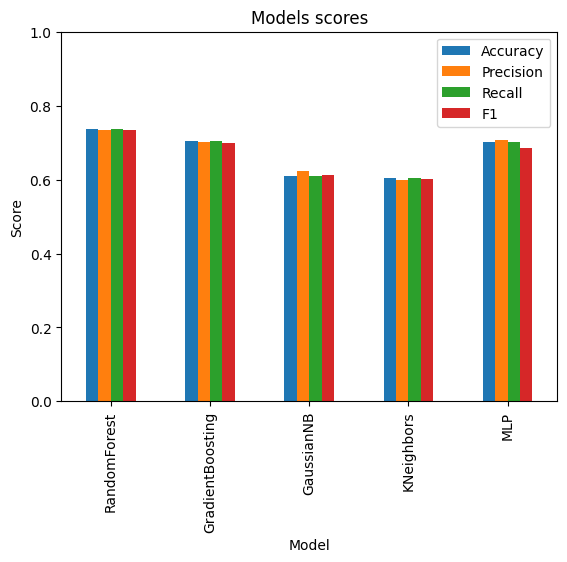

In [56]:
plot_models_scores(scores)

Now we just try to remove some features from the dataset. We will check the matrix of correlation and remove the features that are highly correlated. Plus, let's try with Shap.

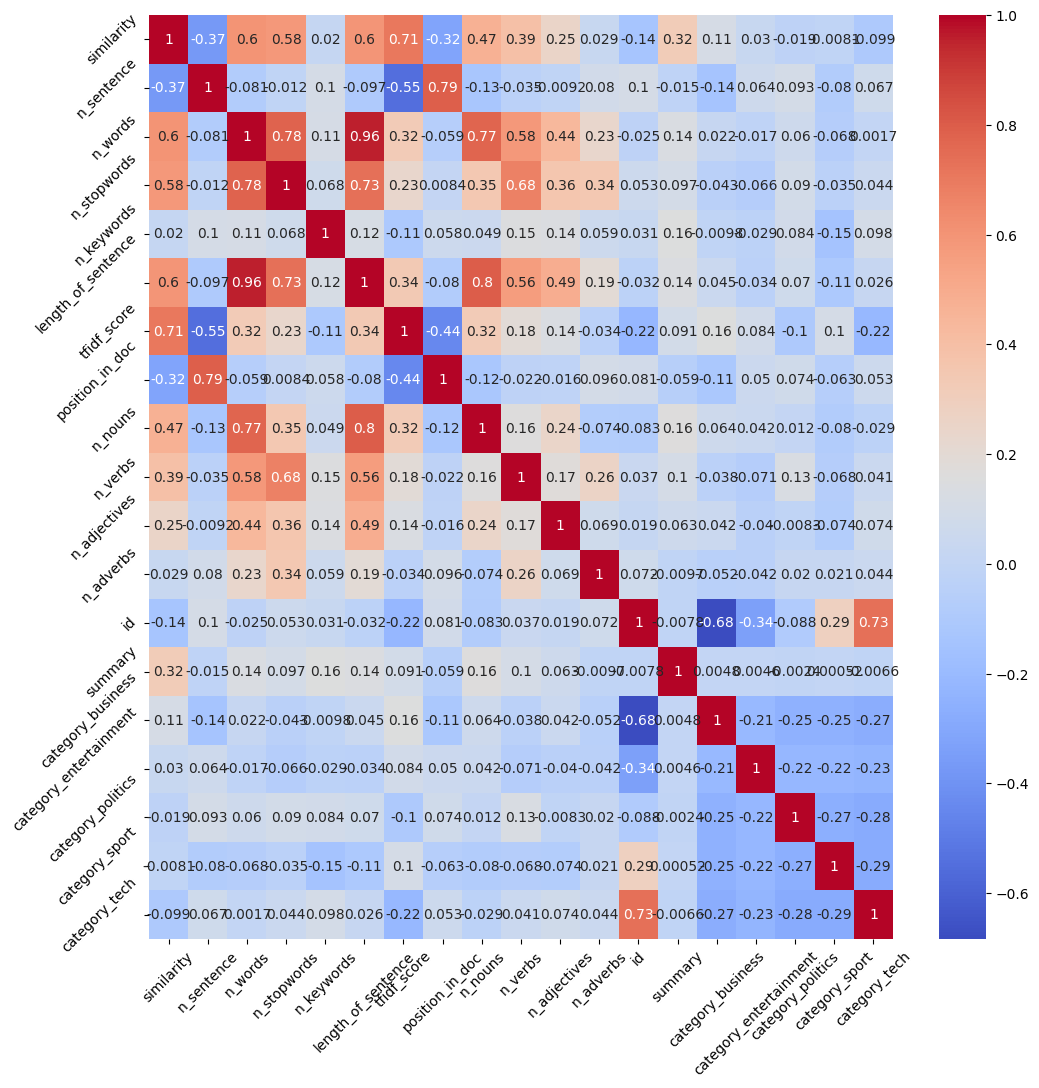

In [47]:
# Correlation matrix
correlation = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

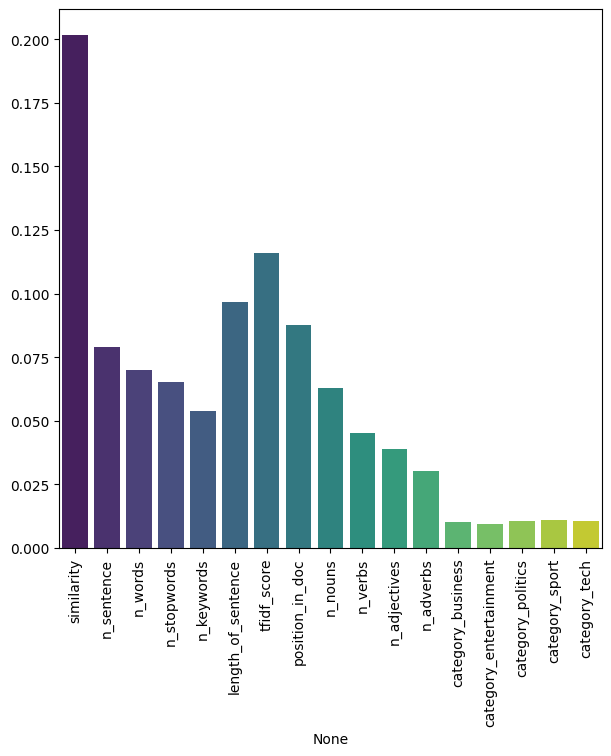

In [50]:
import seaborn as sns
# We use RandomForest since it's the best one
model = models["RandomForest"]
importances = model.feature_importances_

plt.figure(figsize=(7, 7))
sns.barplot(x=X.columns, y=importances, palette="viridis")
plt.xticks(rotation=90)
plt.show()


Looking at this correlation matrix we can see that there are some features that are highly correlated. We will remove them and see if the model improves.

- n_words 
- length_of_sentence
- of course the id
- categories can be removed too
  

In [ ]:
import shap

# RUN THIS ONLY IF YOU HAVE 1 HOUR TO WAIT

# explainer = shap.TreeExplainer(models["RandomForest"])
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The above comment is to evaluate features importance using Shapley values. 
The problem here is computationally difficult, so it was taking too long to run. To avoid stressing locally our machines, it was executed on a 
[Kaggle notebook]( https://www.kaggle.com/code/danieleavolio/shap-ipr/edit ) . It took ~1:15h to run. The resulting graph can be seen here. 

<img width="600px" src="shap.png">

Watching the graph we cna see that here are some features that are not important at all. We will remove them and see if the model improves.

Training RandomForest model
Accuracy: 0.7339128335144272
Confusion matrix: 
 [[3960  876]
 [1328 2119]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.75      0.82      0.78      4836
         1.0       0.71      0.61      0.66      3447

    accuracy                           0.73      8283
   macro avg       0.73      0.72      0.72      8283
weighted avg       0.73      0.73      0.73      8283



Training GradientBoosting model
Accuracy: 0.705420741277315
Confusion matrix: 
 [[3897  939]
 [1501 1946]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      4836
         1.0       0.67      0.56      0.61      3447

    accuracy                           0.71      8283
   macro avg       0.70      0.69      0.69      8283
weighted avg       0.70      0.71      0.70      8283



Training GaussianNB model
Accuracy: 0.6130628999154896
Confusion matrix: 
 [[2933

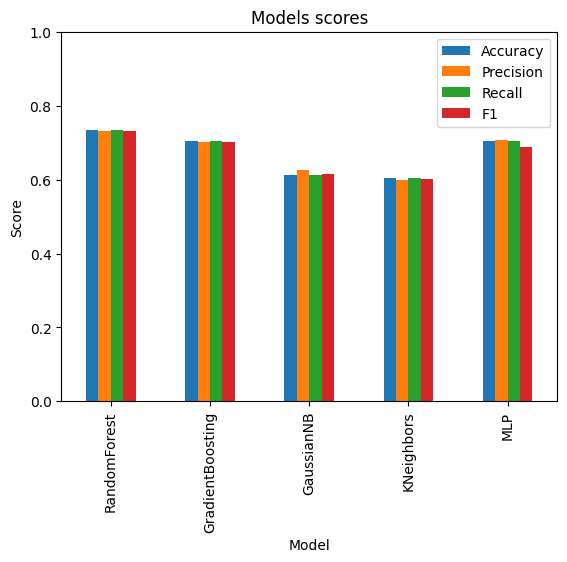

In [57]:
# Redo the split for the new training with different features
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for category, data in categories.items():
    X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(
        data.drop(columns=["id", "category_business", "category_entertainment", "category_politics", "category_sport", "category_tech", "length_of_sentence", "summary"]), data["summary"], test_size=0.2
    )

    X_train = pd.concat([X_train, X_train_category])
    X_test = pd.concat([X_test, X_test_category])
    y_train = pd.concat([y_train, y_train_category])
    y_test = pd.concat([y_test, y_test_category])


scores = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1"], index=models.keys())
# Train each model
for name, model in models.items():
    print(f"Training {name} model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification report: \n {classification_report(y_test, y_pred)}")
    print("\n")
    scores.loc[name] = [accuracy, precision, recall, f1]

plot_models_scores(scores)

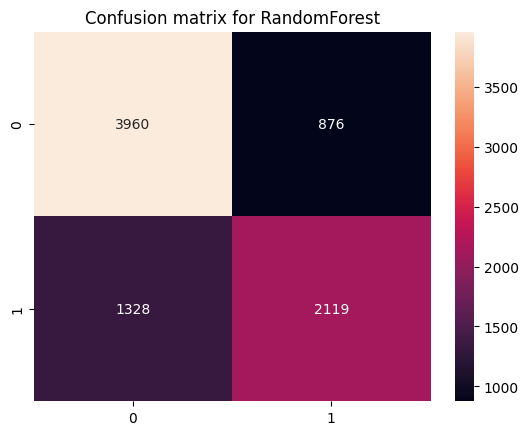

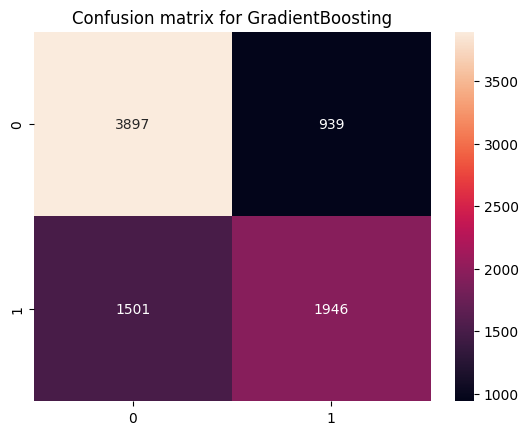

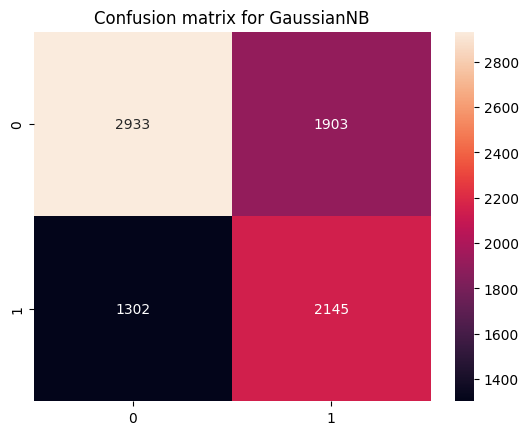

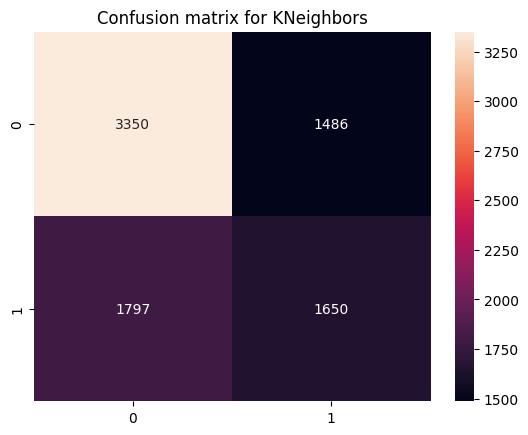

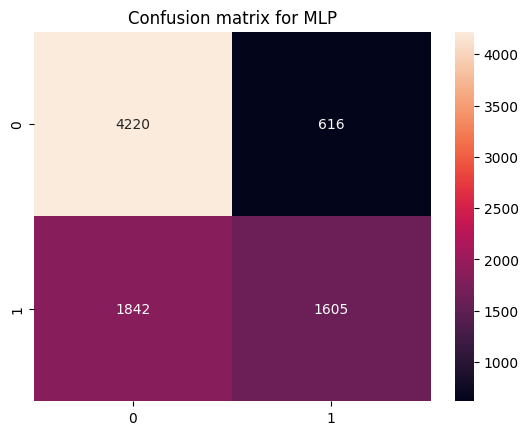

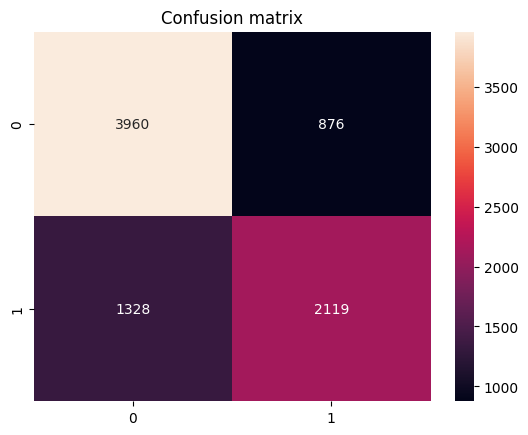

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrixes(models, X_test, y_test):
    for name, model in models.items():
        plt.figure()
        cm = confusion_matrix(y_test, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f"Confusion matrix for {name}")
        plt.show()


def plot_confusion_matrix(model, X_test, y_test):
    plt.figure()
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.show()

plot_confusion_matrixes(models, X_test, y_test)
plot_confusion_matrix(models["RandomForest"], X_test, y_test)

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve_models(models, X_test, y_test):

    plt.figure()
    for name, model in models.items():
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:0.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


def plot_roc_curve(model, X_test, y_test):
    plt.figure()
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:0.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"ROC curve")
    plt.show()

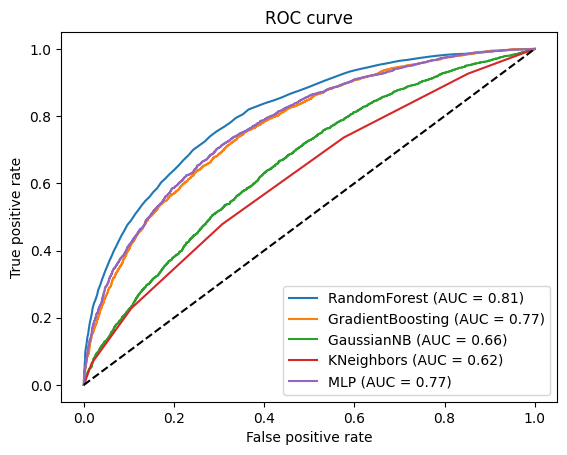

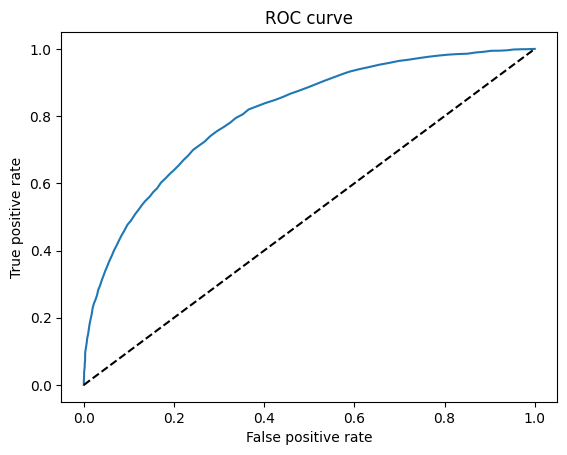

In [60]:
plot_roc_curve_models(models, X_test, y_test)
plot_roc_curve(models["RandomForest"], X_test, y_test)

*C) Ranking extension*

This should be the step we did before, to add more features to the dataset.

*C2) Summarization*

In [61]:
def preprocess_text(doc:str, columns:list, **kwargs):
    sentences = nltk.sent_tokenize(doc)
    features = []
    for sentence in sentences:
        feature = feature_extraction(sentence, doc)
        features.append(feature)

    
    df = pd.DataFrame(features, columns=columns)
    df = df.drop(columns=["category", "length_of_sentence"])
    
    return df
    

def summarization_2(doc:any, M:any, p:int=-1, l:int=-1, columns:list=None, **kwargs):
    
    # To have the phrase as the model trained
    pdf = preprocess_text(doc, columns)

    sentences = nltk.sent_tokenize(doc)
    
    summary = []

    char_left = l
    num_sent = p

    # The actual predictions
    predicted = []
    predicted = M.predict(pdf)

    # The probabilities to choose the best sentences
    probabilities = M.predict_proba(pdf)[:, 1] 
    sorted_indices = np.argsort(probabilities)[::-1] 

    for index in sorted_indices:
        if predicted[index] == 1 and (num_sent == -1 or len(summary) < num_sent):
            if(char_left == -1 or len(sentences[index]) <= char_left):
                summary.append(sentences[index])

    return " ".join(summary)

In [62]:
# Test with some documents
doc_index = 0
doc = documents[doc_index]

columns = [
        "similarity",
        "n_sentence",
        "n_words",
        "n_stopwords",
        "n_keywords",
        "length_of_sentence",
        "tfidf_score",
        "position_in_doc",
        "category",
        "n_nouns",
        "n_verbs",
        "n_adjectives",
        "n_adverbs",
]

summarization_2(doc, models["RandomForest"], p=3, l=100, columns=columns)

'TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Time Warner said on Friday that it now owns 8% of search-engine Google.'

In [63]:
my_doc = """Metin2 is a MMORPG game that is played by millions of people, but it is not as popular as it used to be. The game was released in 2004 and it was developed by Ymir Entertainment and published by Gameforge.

It was very popular in the 2000s and it is still played by many people today, but it is not as popular as it used to be.

The problem was that the game was not updated for a long time and the players started to leave the game.

Moreover, the game was not balanced and the players were not happy with the game.

Dungeons were too hard and the rewards were not good enough, so the players were not motivated to play the game.

Unluckily, Gameforge did not listen to the players and the game started to lose its popularity.
"""

summarization_2(my_doc, models["RandomForest"], p=5, l=150, columns=columns)

'Moreover, the game was not balanced and the players were not happy with the game. The problem was that the game was not updated for a long time and the players started to leave the game. It was very popular in the 2000s and it is still played by many people today, but it is not as popular as it used to be. Metin2 is a MMORPG game that is played by millions of people, but it is not as popular as it used to be. Dungeons were too hard and the rewards were not good enough, so the players were not motivated to play the game.'

*D) Evaluation*

In [64]:
# To select the test documents we will take 20% of the documents from each category

test_docs = []
test_summaries = []

for k,v in categories_ranges.items():
    # take 20% of the documents
    n = int((v[1] - v[0]) * 0.2)
    test_docs += documents[v[0]:v[0] + n]
    test_summaries += summaries[v[0]:v[0] + n]

In [71]:
def supervised_evaluation(D_test, R_test, M, **kwargs):
    # For each document in the test set
    produced_summaries = []
    for doc in D_test:
        produced_summary = summarization_2(doc, M, **kwargs)
        produced_summaries.append(produced_summary)


    confusion_matrix = np.zeros((2, 2))

    for i, produced_summary in enumerate(produced_summaries):
        for sentence in nltk.sent_tokenize(D_test[i]):
            if sentence in R_test[i]:
                if sentence in produced_summary:
                    confusion_matrix[0][0] += 1
                else:
                    confusion_matrix[0][1] += 1
            else:
                if sentence in produced_summary:
                    confusion_matrix[1][0] += 1
                else:
                    confusion_matrix[1][1] += 1

    prec = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
    rec = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
    fone = alternative_f1_score(prec, rec)
    acc = (confusion_matrix[0][0] + confusion_matrix[1][1]) / np.sum(confusion_matrix)


    return confusion_matrix, prec, rec, fone, acc


In [66]:
cm, prec, rec, f1s, acc = supervised_evaluation(
    test_docs, test_summaries, models["RandomForest"], p=6, l=200, columns=columns
)

In [67]:
print(f"Confusion matrix: \n {cm}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 score: {f1s}")
print(f"Accuracy: {acc}")

Confusion matrix: 
 [[2024. 1134.]
 [ 551. 3787.]]
Precision: 0.7860194174757281
Recall: 0.6409119696010133
F1 score: 0.7060875632304202
Accuracy: 0.7752134471718249


*E) Evaluation*


In [68]:
# Let's use the old evaluation function
test_produced_summaries = []
for doc in test_docs:
    summary = summarization_2(doc, models["RandomForest"], p=8, l=200, columns=columns)
    test_produced_summaries.append(summary)

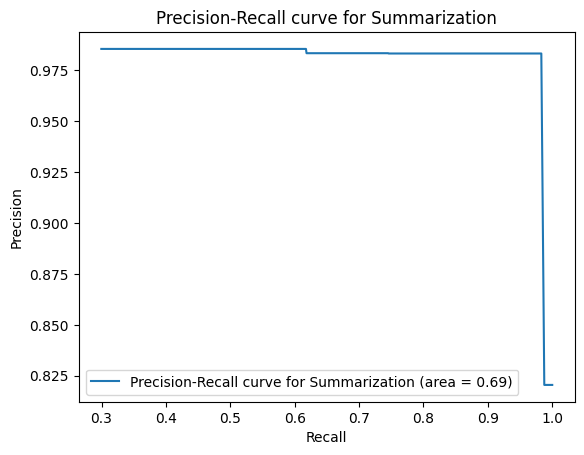


####### Time to process 443 documents: 
 
        - 1.7171545028686523 seconds 

        - 0.0038761952660691925 seconds per document
        


Average precision: 0.7465002960836905
Average recall: 0.7904598422856284
F1 score: 0.7678514121186635
Standard deviation of precision: 0.12080560452149809
Standard deviation of recall: 0.15404571065813433
Mean average precision: 0.6871537845504331


In [75]:
average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(test_produced_summaries, test_summaries, "Summarization")

print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"F1 score: {f1}")
print(f"Standard deviation of precision: {std_precision}")
print(f"Standard deviation of recall: {std_recall}")
print(f"Mean average precision: {m_a_p}")

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

We will run the code on the same category of documents we used to evaluate in the part 1.

For computational choice, we will run only over the `business` category.

In [77]:
# take tech documents
business_docs = documents[categories_ranges["business"][0]:categories_ranges["business"][1]]
business_summaries = summaries[categories_ranges["business"][0]:categories_ranges["business"][1]]

print(f"Number of business documents: {len(business_docs)}")
print(f"Number of business summaries: {len(business_summaries)}")

Number of business documents: 509
Number of business summaries: 509


The data that we are using for the comparison it's from the `First part of the project`, in particular the `Evaluation` part.

```python
average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation("business", ix, max_sentences=5, max_characters=500, order=True, scoring_type="BM25")
```

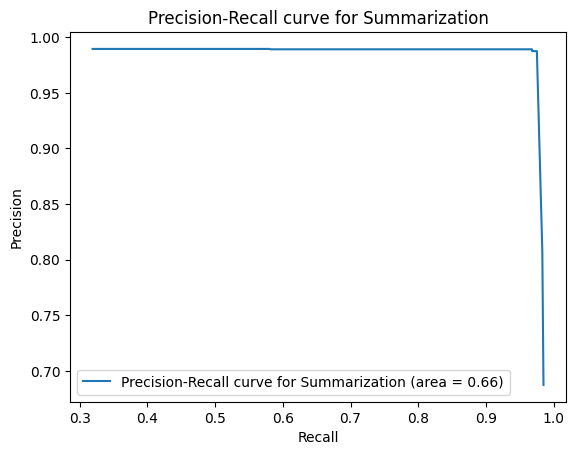


####### Time to process 509 documents: 
 
        - 2.2973151206970215 seconds 

        - 0.004513389235161143 seconds per document
        




In [78]:
tech_produced_summaries = []

for doc in business_docs:
    summary = summarization_2(doc, models["RandomForest"], p=5, l=500, columns=columns)
    tech_produced_summaries.append(summary)

average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(tech_produced_summaries, business_summaries, "Summarization")

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

Our function is written in a way that permits the choice for:
- Max number of clusters
- Max number of sentences
- Metric for clustering

Since we didn't use anything else than TFIDF we can't really say how the sentence representations impact the summarization. We can say that the clustering choices and rank criteria impact the summarization. Let's see the differences

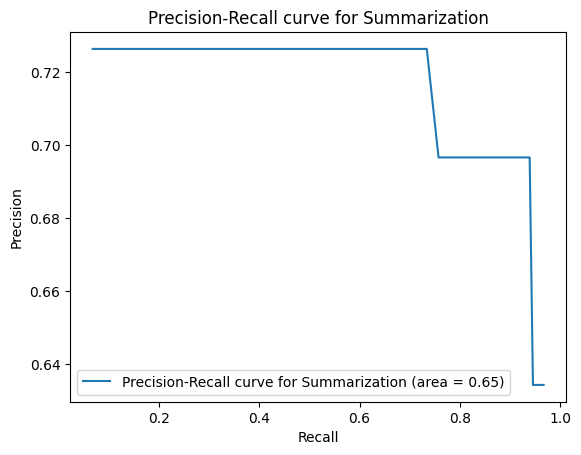


####### Time to process 200 documents: 
 
        - 0.6998958587646484 seconds 

        - 0.003499479293823242 seconds per document
        




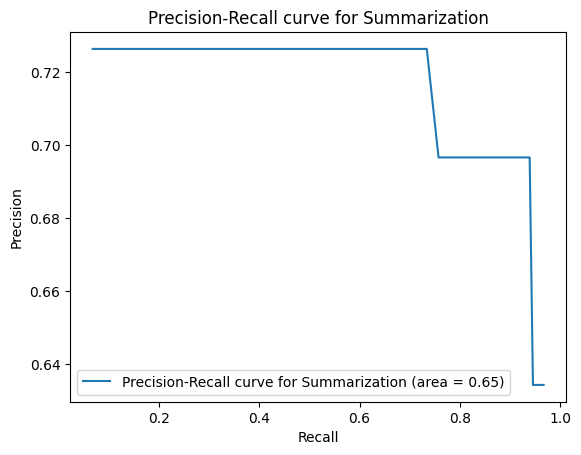


####### Time to process 200 documents: 
 
        - 0.9816789627075195 seconds 

        - 0.0049083948135375975 seconds per document
        




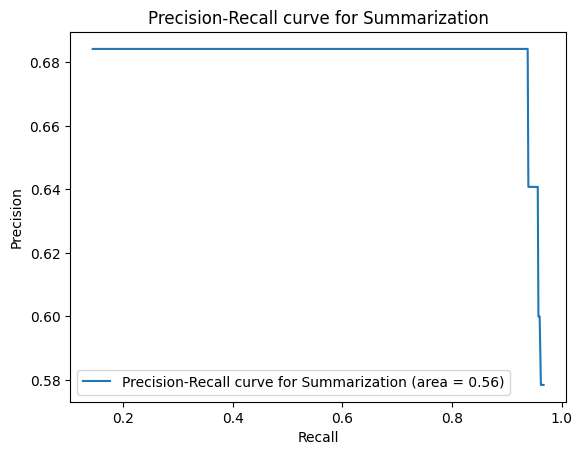


####### Time to process 200 documents: 
 
        - 1.223707675933838 seconds 

        - 0.006118538379669189 seconds per document
        




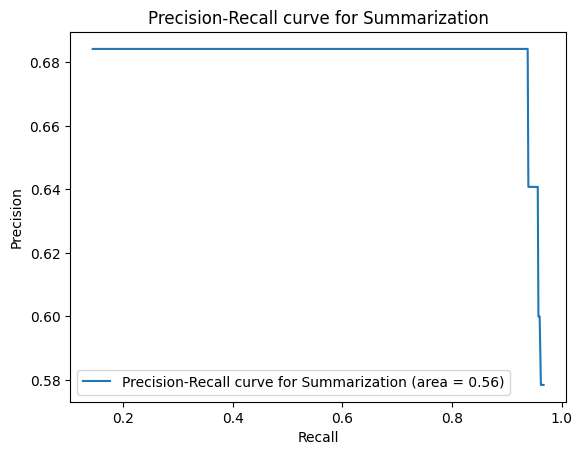


####### Time to process 200 documents: 
 
        - 1.2529327869415283 seconds 

        - 0.006264663934707641 seconds per document
        




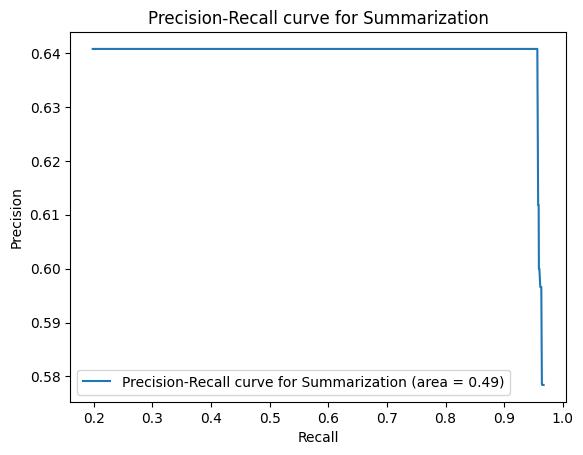


####### Time to process 200 documents: 
 
        - 1.4319605827331543 seconds 

        - 0.007159802913665771 seconds per document
        




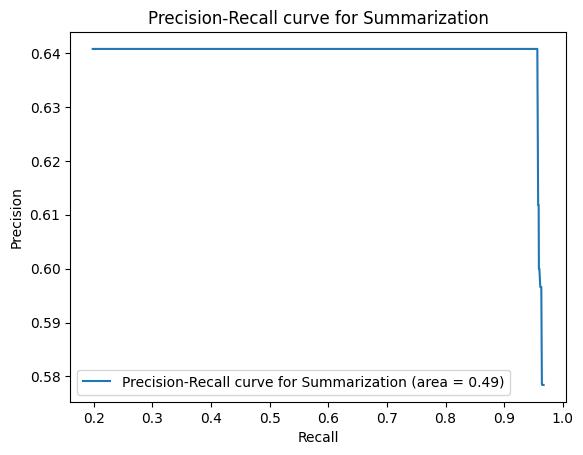


####### Time to process 200 documents: 
 
        - 1.4489479064941406 seconds 

        - 0.007244739532470703 seconds per document
        




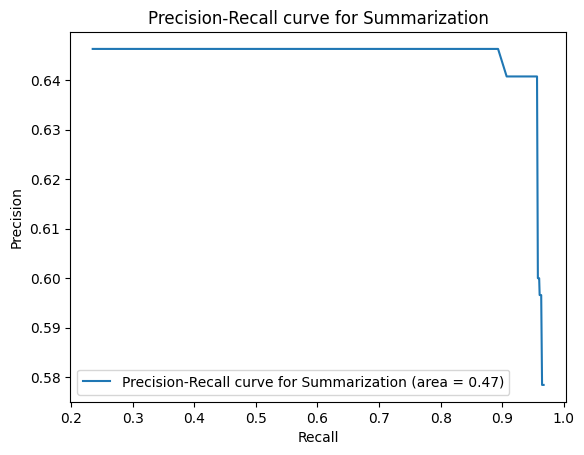


####### Time to process 200 documents: 
 
        - 1.0916523933410645 seconds 

        - 0.005458261966705322 seconds per document
        




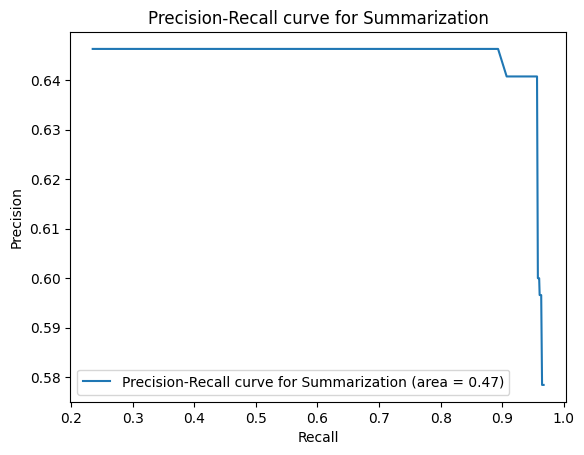


####### Time to process 200 documents: 
 
        - 1.0976347923278809 seconds 

        - 0.005488173961639404 seconds per document
        




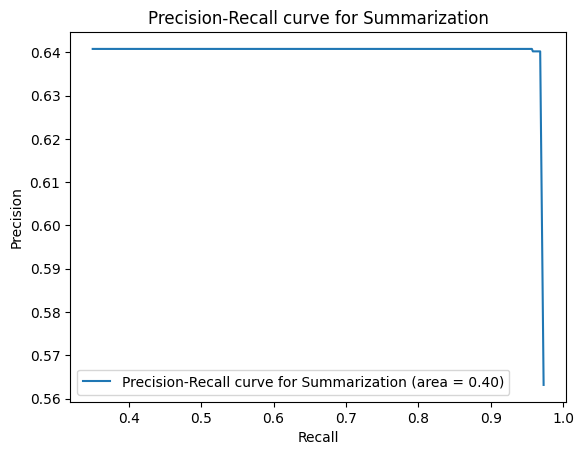


####### Time to process 200 documents: 
 
        - 1.5047497749328613 seconds 

        - 0.0075237488746643065 seconds per document
        




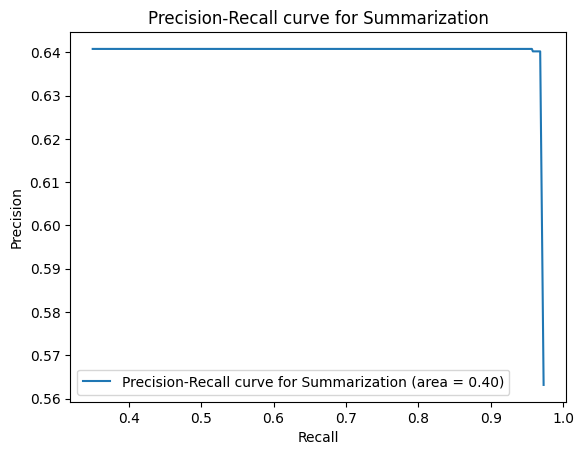


####### Time to process 200 documents: 
 
        - 2.5721657276153564 seconds 

        - 0.012860828638076782 seconds per document
        




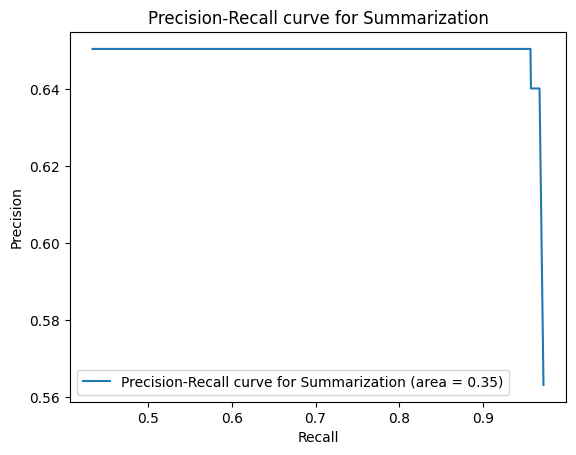


####### Time to process 200 documents: 
 
        - 1.6233952045440674 seconds 

        - 0.008116976022720337 seconds per document
        




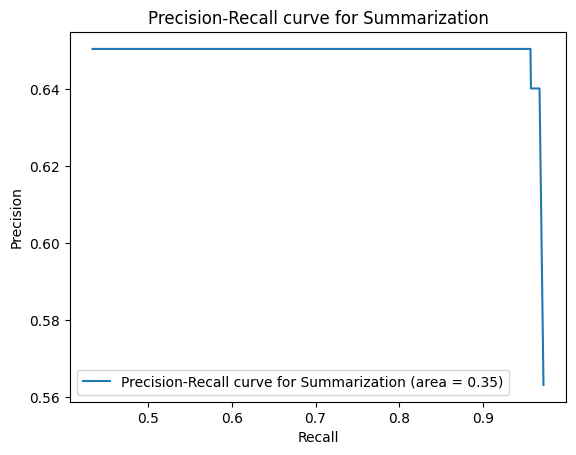


####### Time to process 200 documents: 
 
        - 1.5723838806152344 seconds 

        - 0.007861919403076172 seconds per document
        




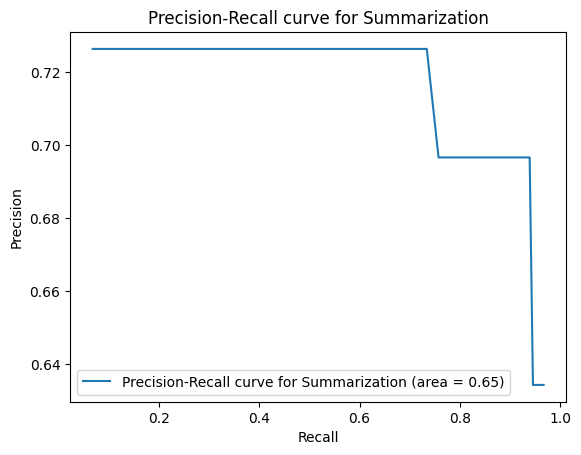


####### Time to process 200 documents: 
 
        - 0.9383337497711182 seconds 

        - 0.004691668748855591 seconds per document
        




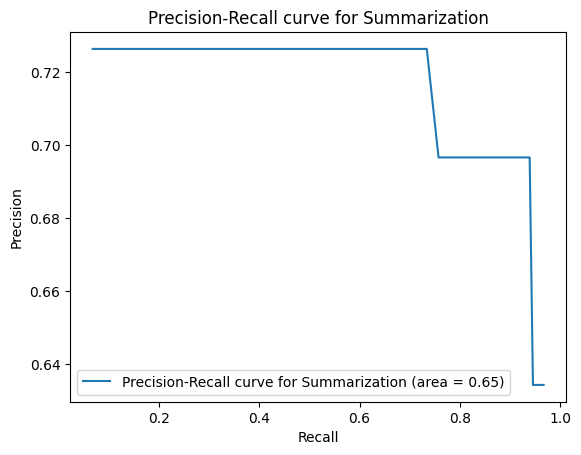


####### Time to process 200 documents: 
 
        - 0.9854881763458252 seconds 

        - 0.004927440881729126 seconds per document
        




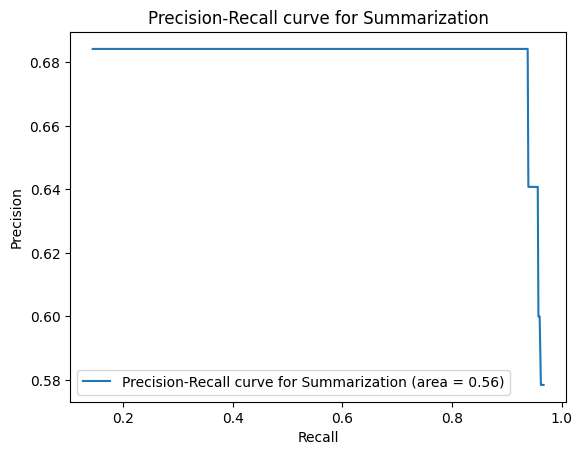


####### Time to process 200 documents: 
 
        - 1.1877026557922363 seconds 

        - 0.005938513278961182 seconds per document
        




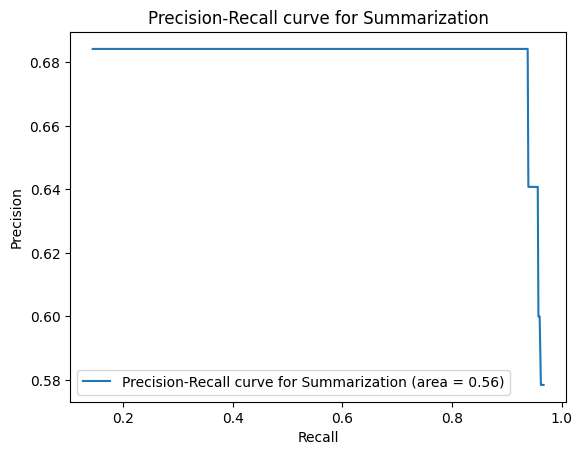


####### Time to process 200 documents: 
 
        - 1.2246320247650146 seconds 

        - 0.006123160123825073 seconds per document
        




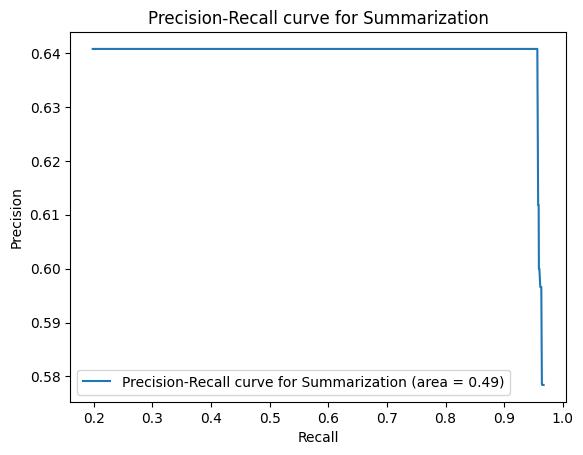


####### Time to process 200 documents: 
 
        - 1.381530523300171 seconds 

        - 0.006907652616500854 seconds per document
        




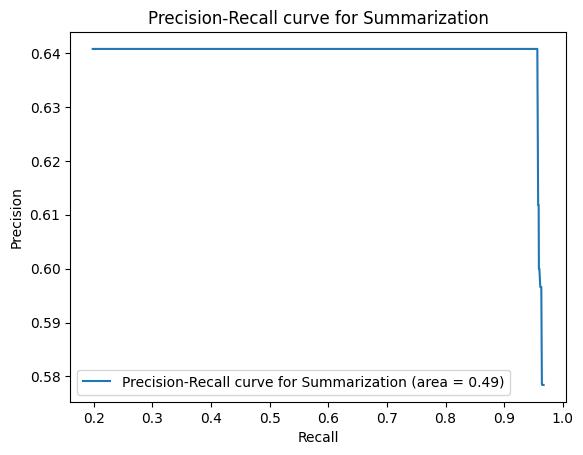


####### Time to process 200 documents: 
 
        - 1.3813648223876953 seconds 

        - 0.0069068241119384765 seconds per document
        




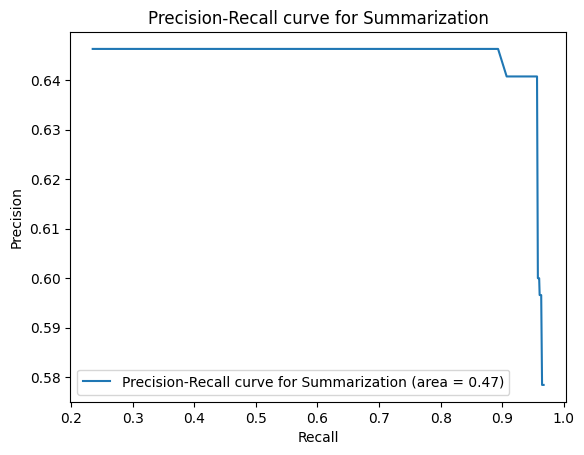


####### Time to process 200 documents: 
 
        - 1.4927384853363037 seconds 

        - 0.007463692426681518 seconds per document
        




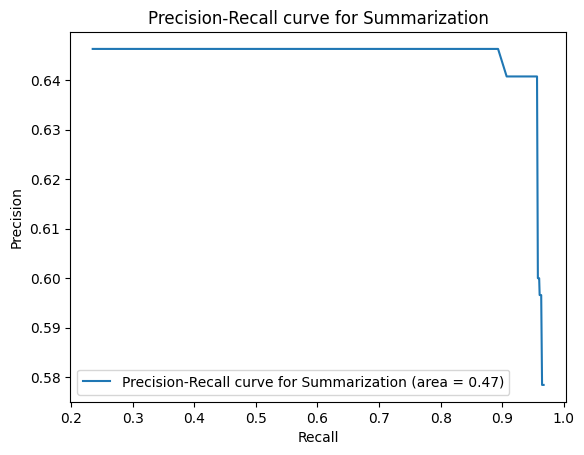


####### Time to process 200 documents: 
 
        - 1.1105823516845703 seconds 

        - 0.005552911758422851 seconds per document
        




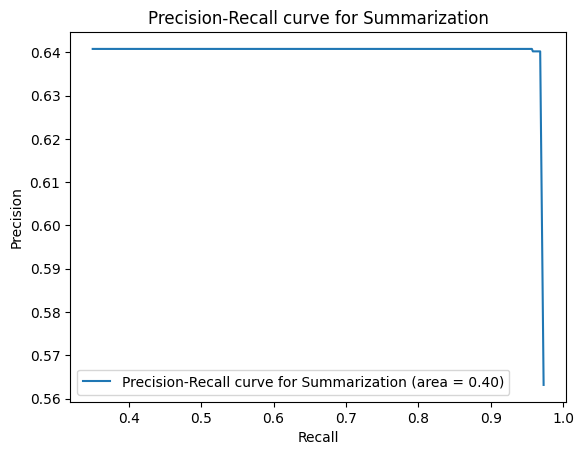


####### Time to process 200 documents: 
 
        - 1.153376579284668 seconds 

        - 0.00576688289642334 seconds per document
        




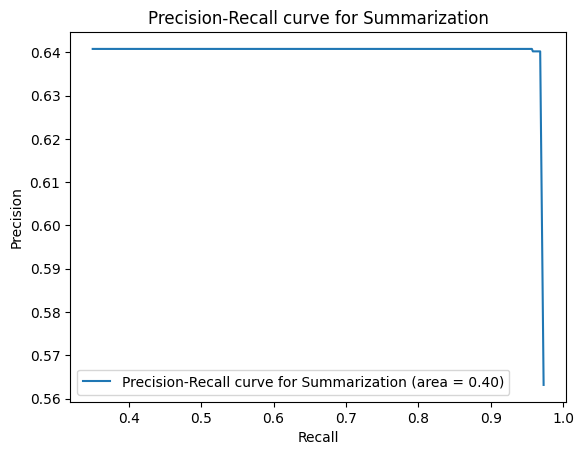


####### Time to process 200 documents: 
 
        - 1.2660467624664307 seconds 

        - 0.006330233812332153 seconds per document
        




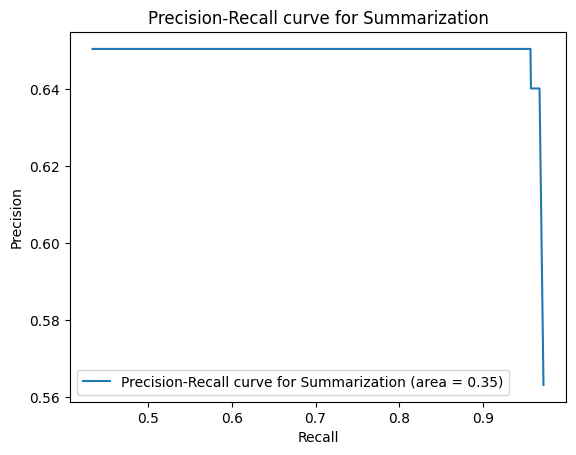


####### Time to process 200 documents: 
 
        - 1.1827480792999268 seconds 

        - 0.005913740396499634 seconds per document
        




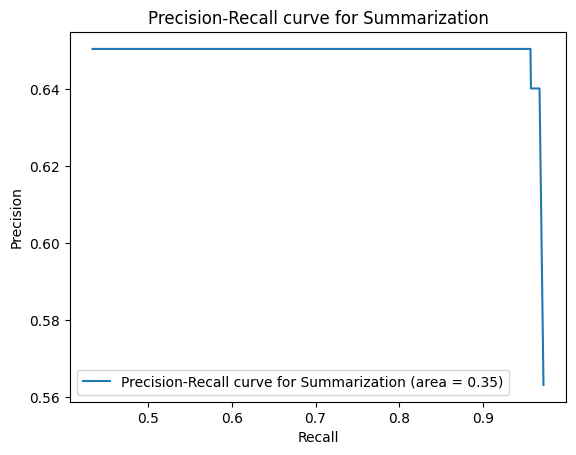


####### Time to process 200 documents: 
 
        - 1.1761689186096191 seconds 

        - 0.0058808445930480955 seconds per document
        




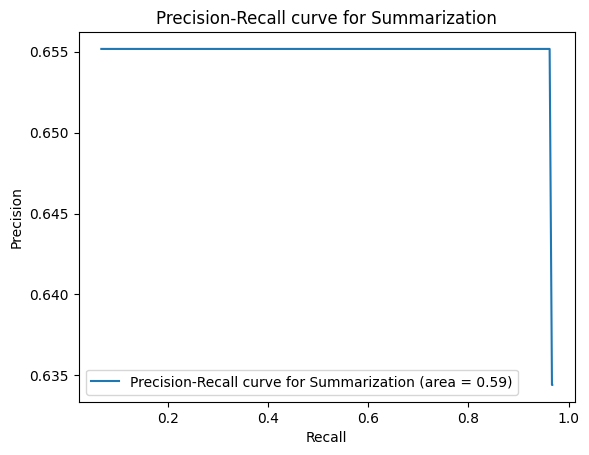


####### Time to process 200 documents: 
 
        - 0.8643994331359863 seconds 

        - 0.004321997165679932 seconds per document
        




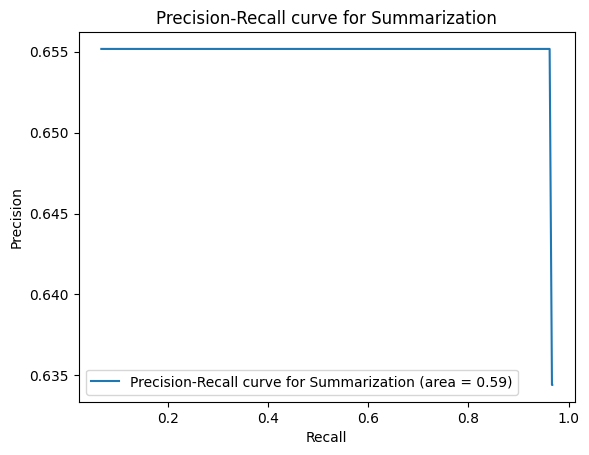


####### Time to process 200 documents: 
 
        - 0.7968695163726807 seconds 

        - 0.003984347581863403 seconds per document
        




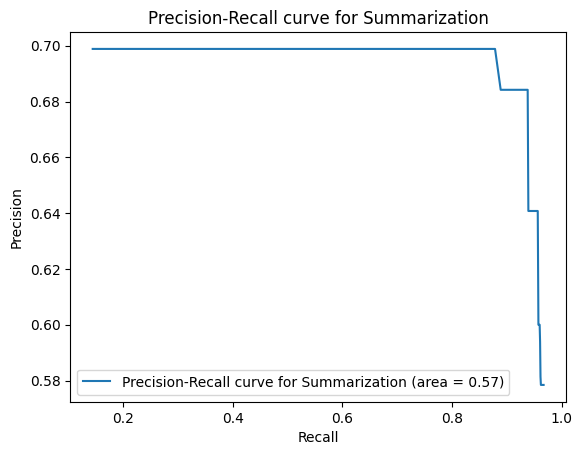


####### Time to process 200 documents: 
 
        - 0.9866182804107666 seconds 

        - 0.004933091402053833 seconds per document
        




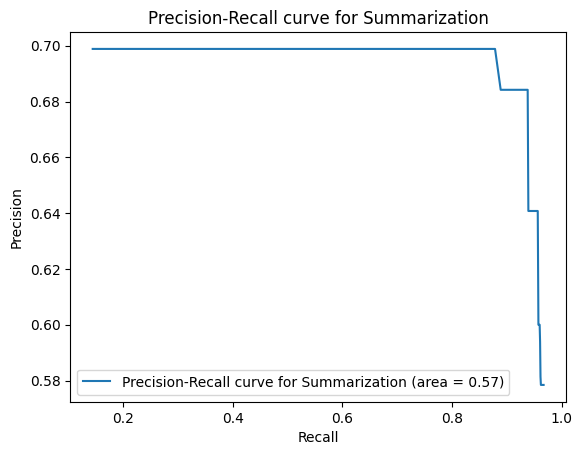


####### Time to process 200 documents: 
 
        - 1.0208473205566406 seconds 

        - 0.005104236602783203 seconds per document
        




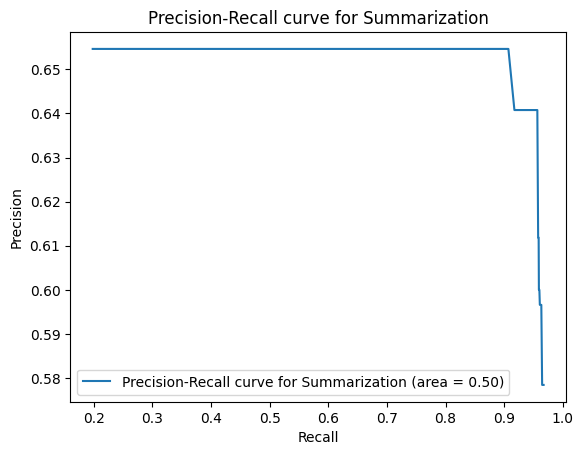


####### Time to process 200 documents: 
 
        - 1.046790599822998 seconds 

        - 0.0052339529991149904 seconds per document
        




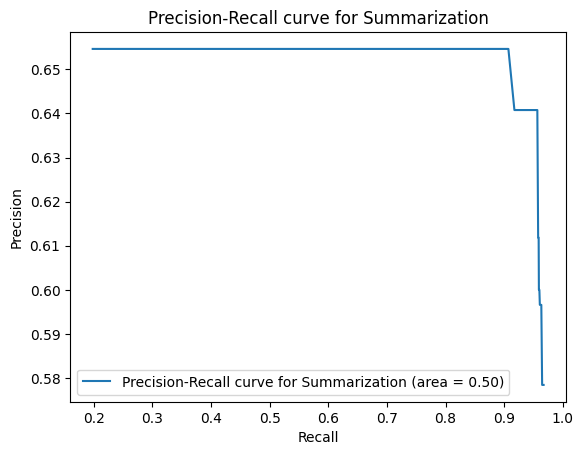


####### Time to process 200 documents: 
 
        - 1.051065444946289 seconds 

        - 0.005255327224731445 seconds per document
        




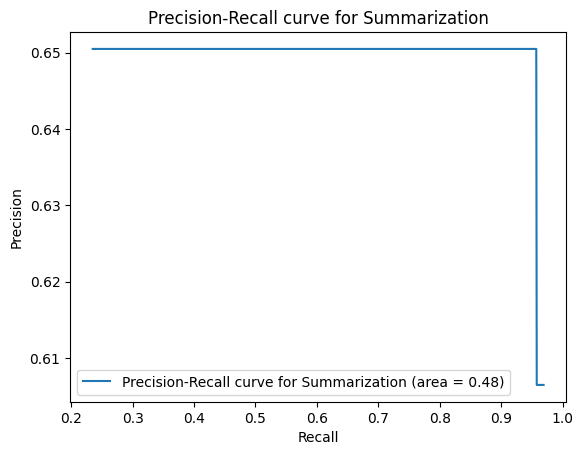


####### Time to process 200 documents: 
 
        - 1.100921630859375 seconds 

        - 0.005504608154296875 seconds per document
        




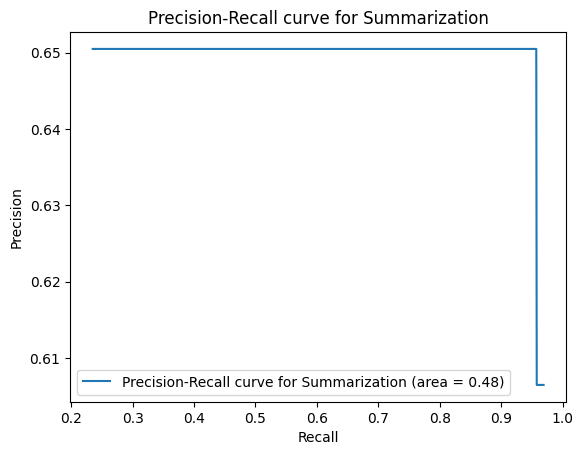


####### Time to process 200 documents: 
 
        - 1.10557222366333 seconds 

        - 0.00552786111831665 seconds per document
        




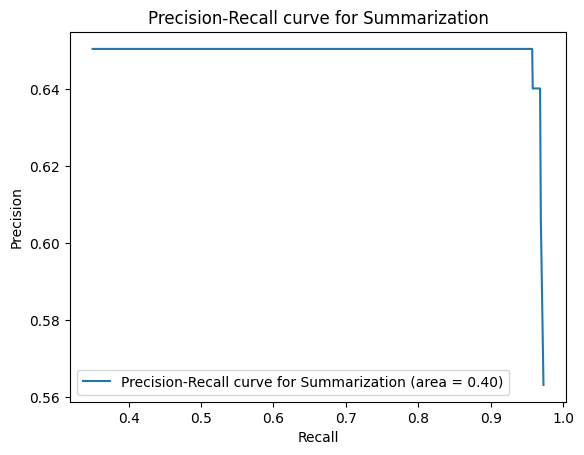


####### Time to process 200 documents: 
 
        - 1.1860826015472412 seconds 

        - 0.0059304130077362065 seconds per document
        




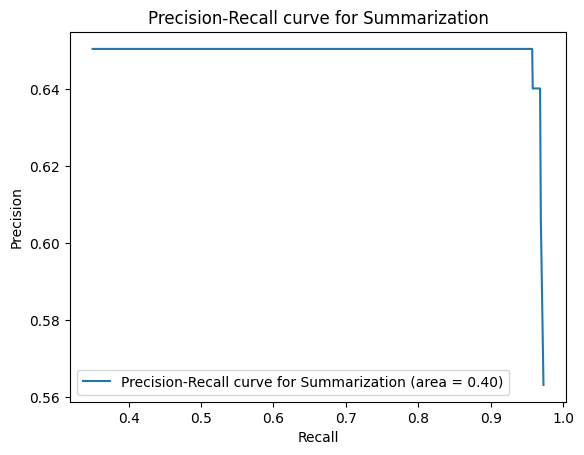


####### Time to process 200 documents: 
 
        - 1.1278679370880127 seconds 

        - 0.005639339685440063 seconds per document
        




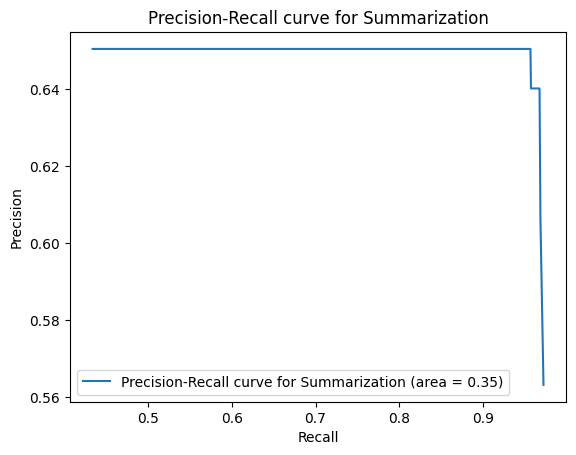


####### Time to process 200 documents: 
 
        - 1.1329526901245117 seconds 

        - 0.005664763450622559 seconds per document
        




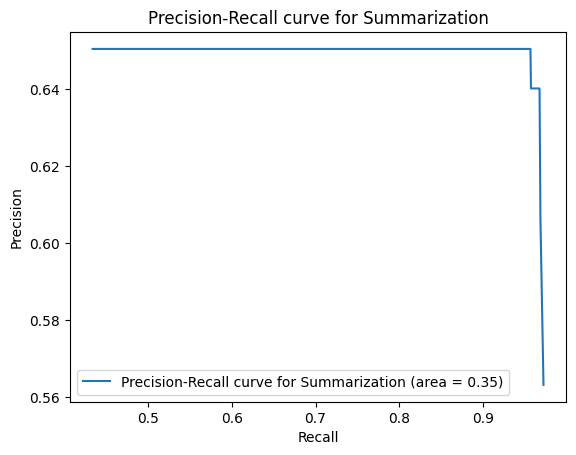


####### Time to process 200 documents: 
 
        - 1.1722490787506104 seconds 

        - 0.005861245393753052 seconds per document
        




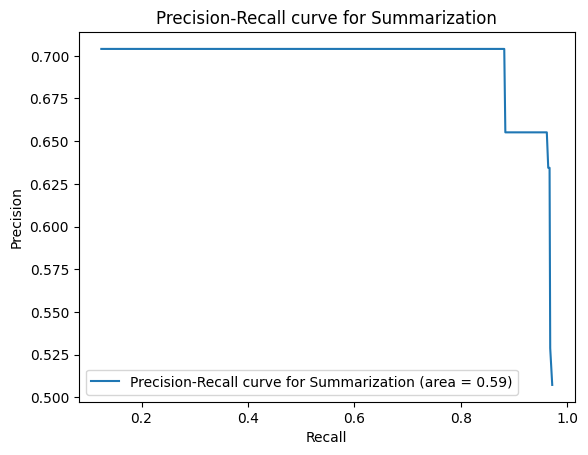


####### Time to process 200 documents: 
 
        - 0.911113977432251 seconds 

        - 0.004555569887161255 seconds per document
        




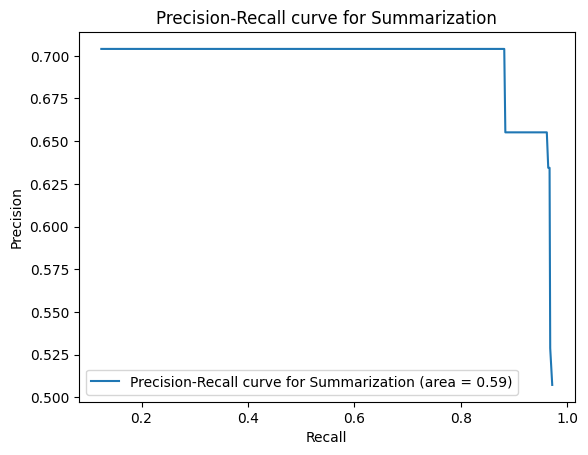


####### Time to process 200 documents: 
 
        - 0.9148097038269043 seconds 

        - 0.004574048519134522 seconds per document
        




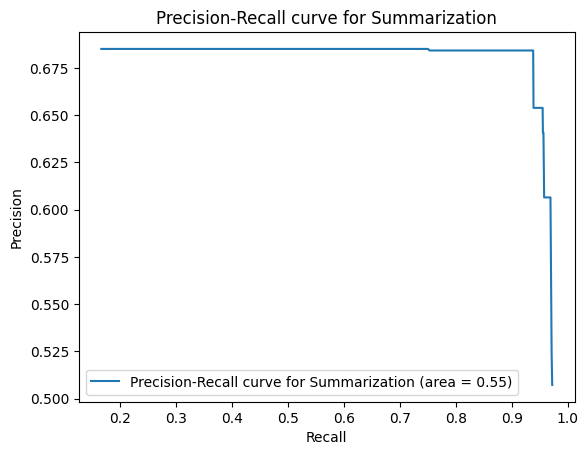


####### Time to process 200 documents: 
 
        - 1.507387399673462 seconds 

        - 0.00753693699836731 seconds per document
        




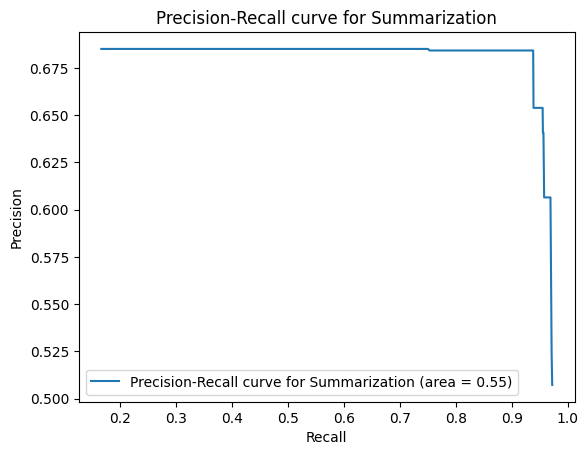


####### Time to process 200 documents: 
 
        - 1.4638137817382812 seconds 

        - 0.007319068908691407 seconds per document
        




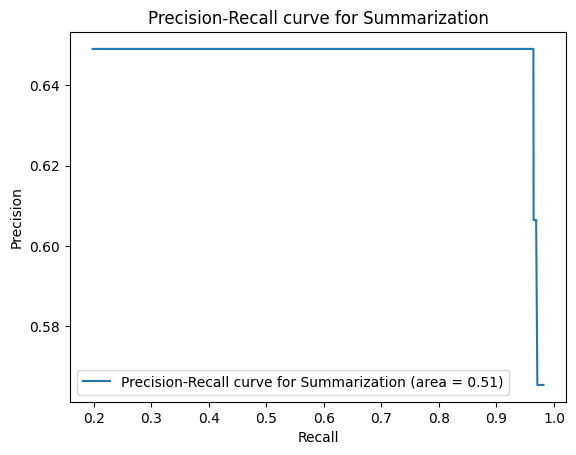


####### Time to process 200 documents: 
 
        - 1.5054197311401367 seconds 

        - 0.007527098655700683 seconds per document
        




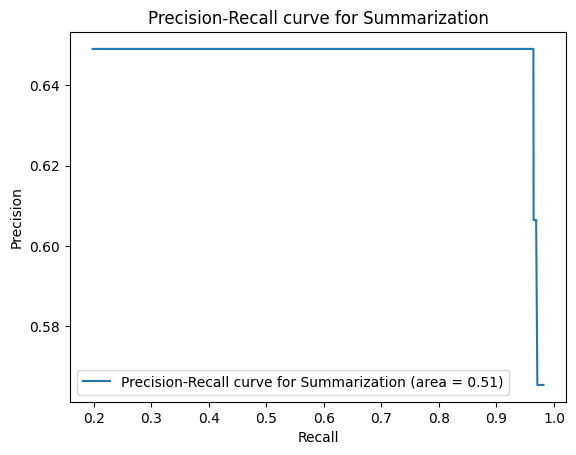


####### Time to process 200 documents: 
 
        - 1.5162107944488525 seconds 

        - 0.0075810539722442625 seconds per document
        




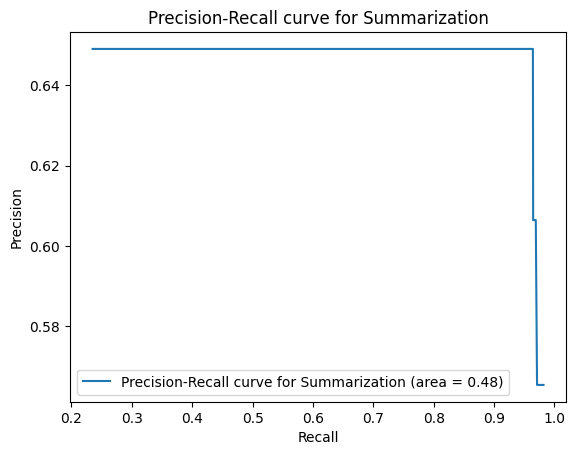


####### Time to process 200 documents: 
 
        - 1.547377347946167 seconds 

        - 0.007736886739730835 seconds per document
        




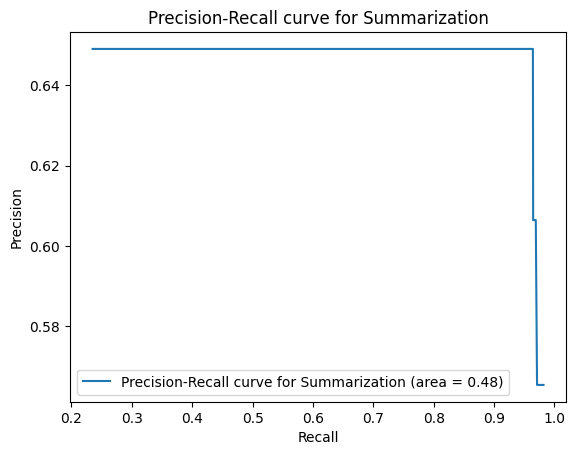


####### Time to process 200 documents: 
 
        - 1.7618496417999268 seconds 

        - 0.008809248208999634 seconds per document
        




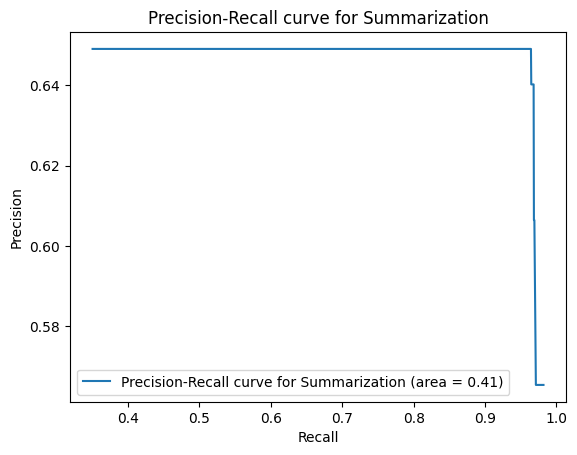


####### Time to process 200 documents: 
 
        - 1.737379550933838 seconds 

        - 0.008686897754669189 seconds per document
        




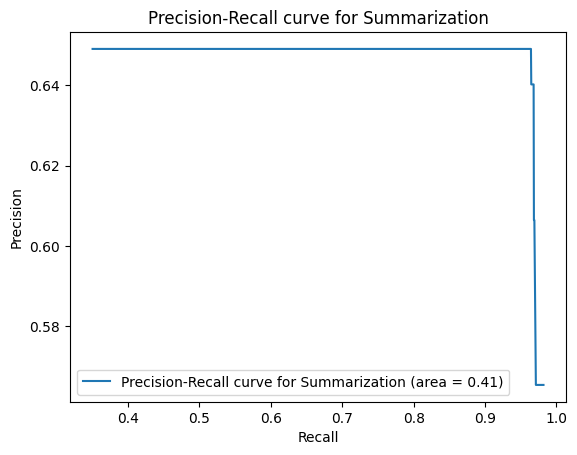


####### Time to process 200 documents: 
 
        - 1.6958796977996826 seconds 

        - 0.008479398488998414 seconds per document
        




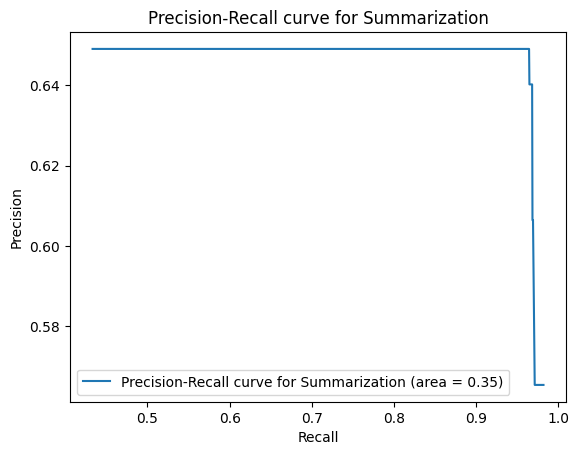


####### Time to process 200 documents: 
 
        - 1.6932153701782227 seconds 

        - 0.008466076850891114 seconds per document
        




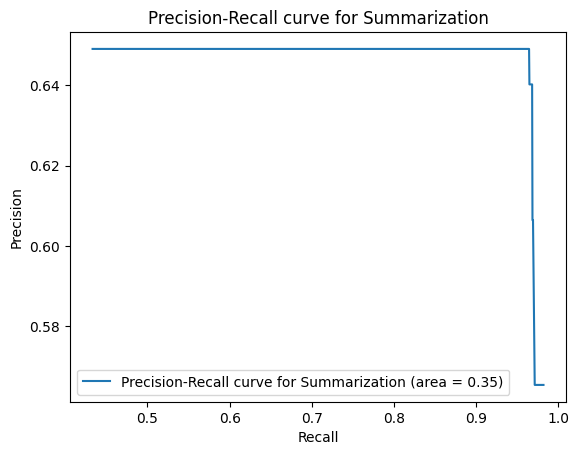


####### Time to process 200 documents: 
 
        - 1.5910871028900146 seconds 

        - 0.007955435514450073 seconds per document
        




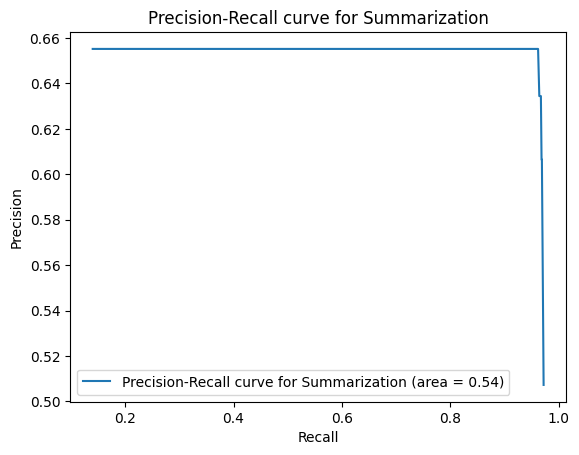


####### Time to process 200 documents: 
 
        - 1.3058233261108398 seconds 

        - 0.006529116630554199 seconds per document
        




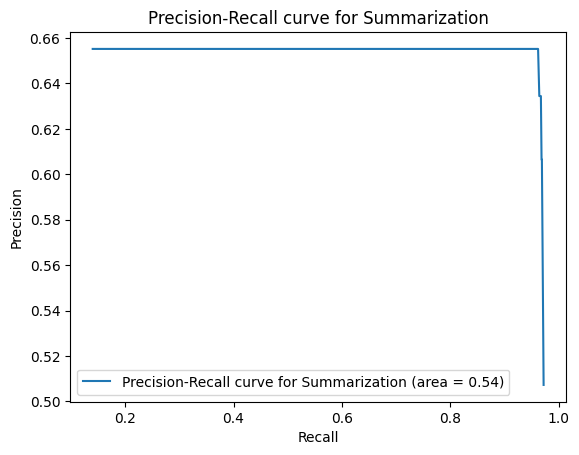


####### Time to process 200 documents: 
 
        - 1.301640272140503 seconds 

        - 0.006508201360702515 seconds per document
        




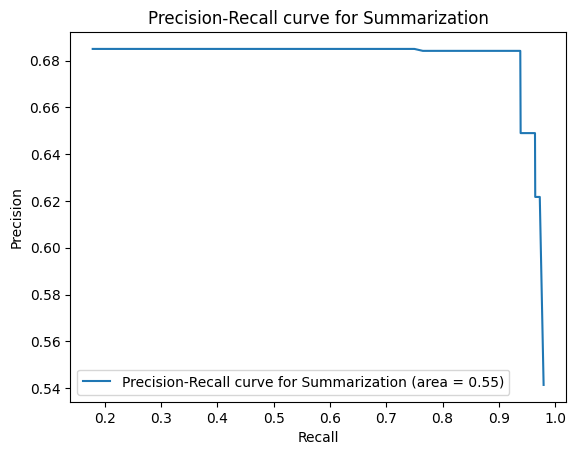


####### Time to process 200 documents: 
 
        - 1.4896678924560547 seconds 

        - 0.007448339462280273 seconds per document
        




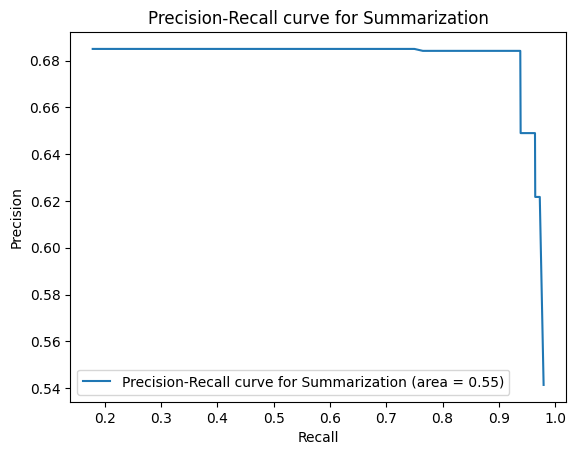


####### Time to process 200 documents: 
 
        - 1.4816758632659912 seconds 

        - 0.007408379316329956 seconds per document
        




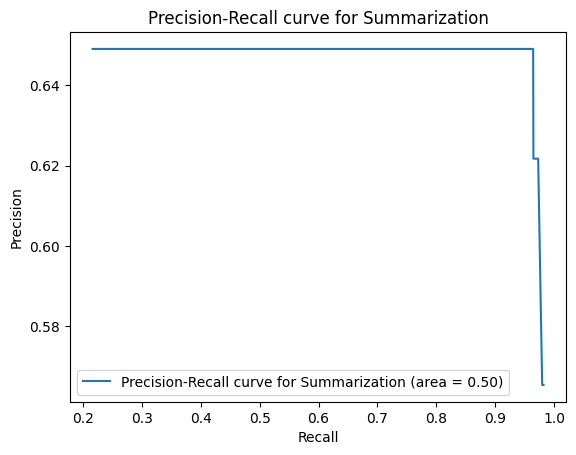


####### Time to process 200 documents: 
 
        - 1.4979603290557861 seconds 

        - 0.007489801645278931 seconds per document
        




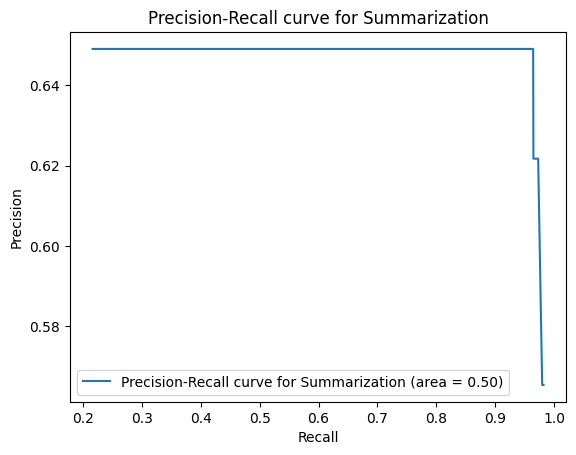


####### Time to process 200 documents: 
 
        - 1.531886339187622 seconds 

        - 0.0076594316959381105 seconds per document
        




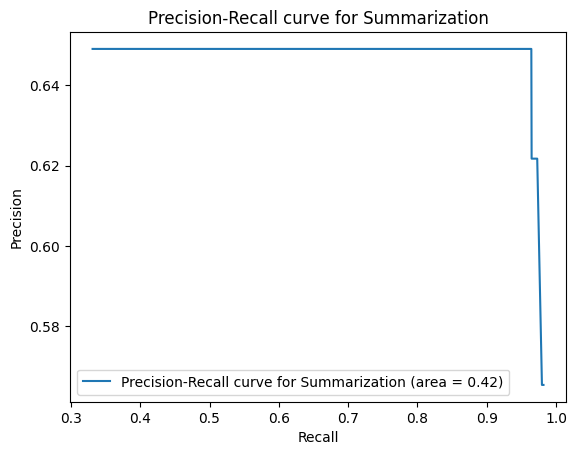


####### Time to process 200 documents: 
 
        - 1.6167218685150146 seconds 

        - 0.008083609342575073 seconds per document
        




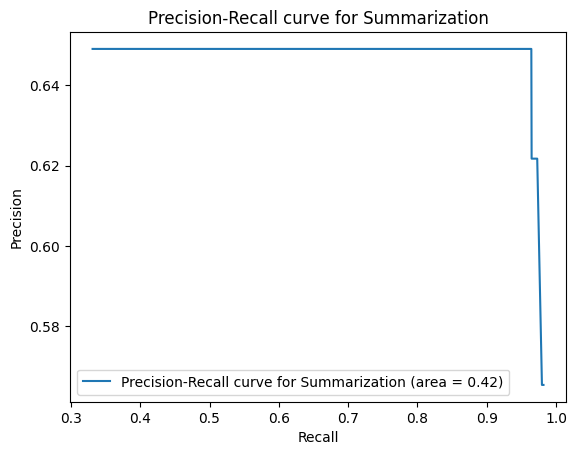


####### Time to process 200 documents: 
 
        - 1.5433576107025146 seconds 

        - 0.007716788053512573 seconds per document
        




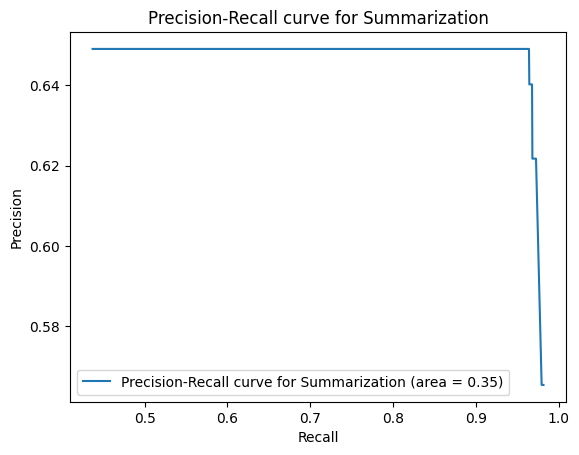


####### Time to process 200 documents: 
 
        - 1.7589056491851807 seconds 

        - 0.008794528245925904 seconds per document
        




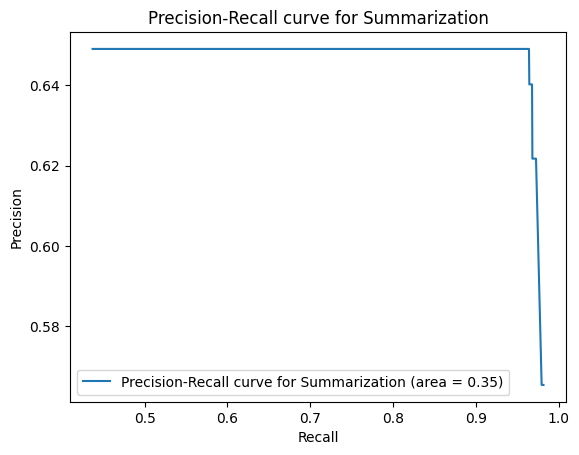


####### Time to process 200 documents: 
 
        - 1.1588761806488037 seconds 

        - 0.005794380903244019 seconds per document
        




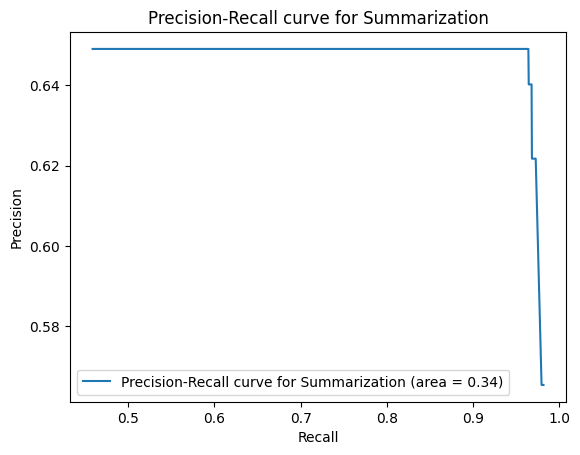


####### Time to process 200 documents: 
 
        - 1.1419663429260254 seconds 

        - 0.005709831714630127 seconds per document
        




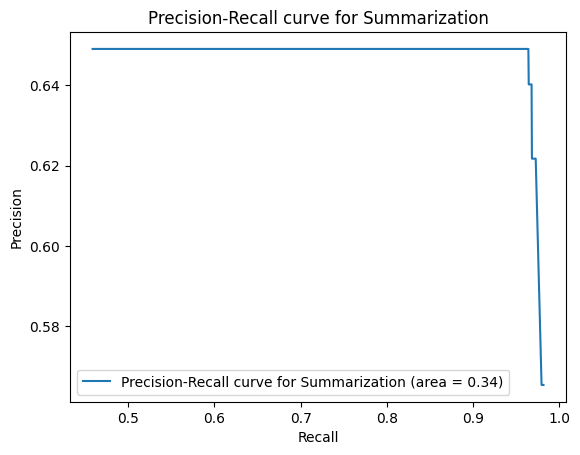


####### Time to process 200 documents: 
 
        - 1.173513650894165 seconds 

        - 0.005867568254470826 seconds per document
        




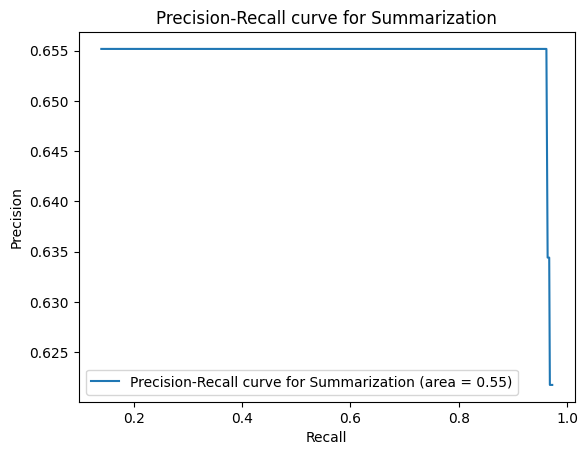


####### Time to process 200 documents: 
 
        - 1.367518424987793 seconds 

        - 0.0068375921249389645 seconds per document
        




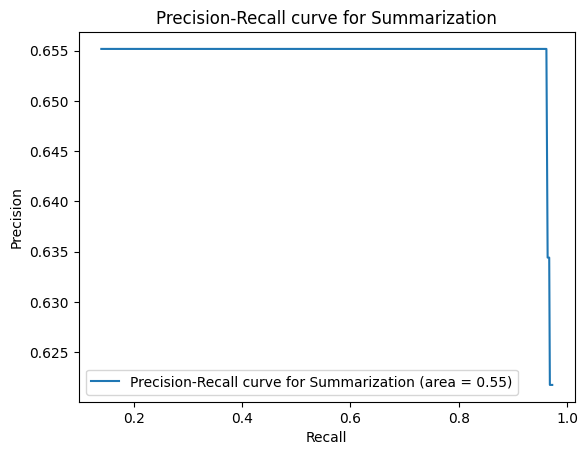


####### Time to process 200 documents: 
 
        - 1.363978385925293 seconds 

        - 0.006819891929626465 seconds per document
        




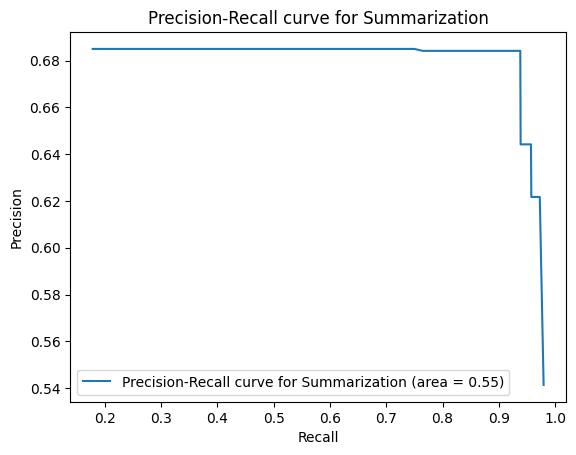


####### Time to process 200 documents: 
 
        - 1.5075619220733643 seconds 

        - 0.007537809610366822 seconds per document
        




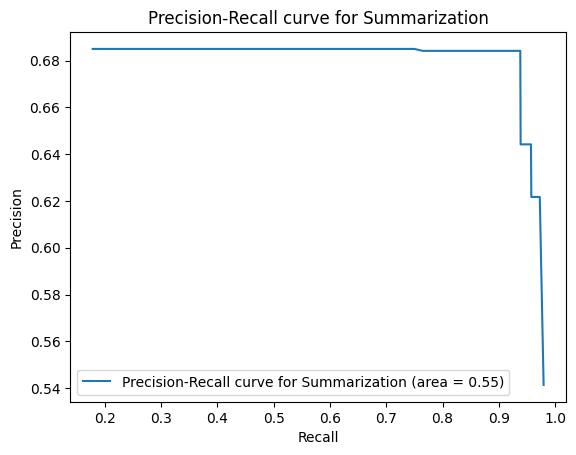


####### Time to process 200 documents: 
 
        - 1.5123662948608398 seconds 

        - 0.007561831474304199 seconds per document
        




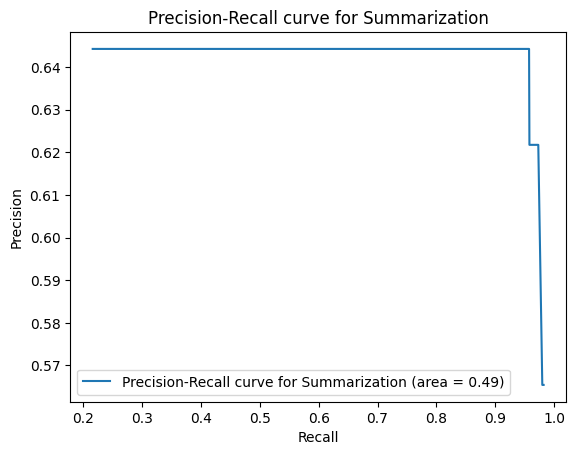


####### Time to process 200 documents: 
 
        - 1.5715301036834717 seconds 

        - 0.007857650518417358 seconds per document
        




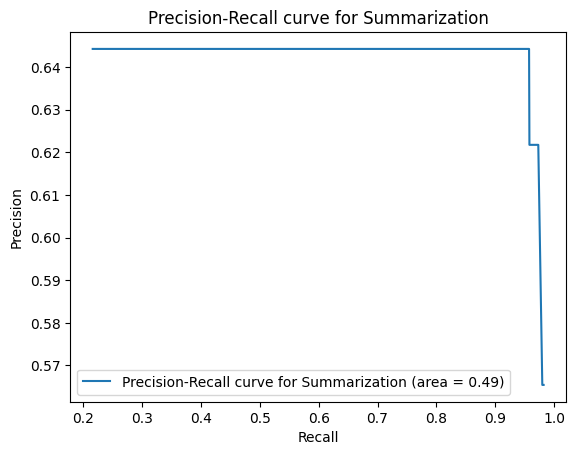


####### Time to process 200 documents: 
 
        - 1.8509466648101807 seconds 

        - 0.009254733324050904 seconds per document
        




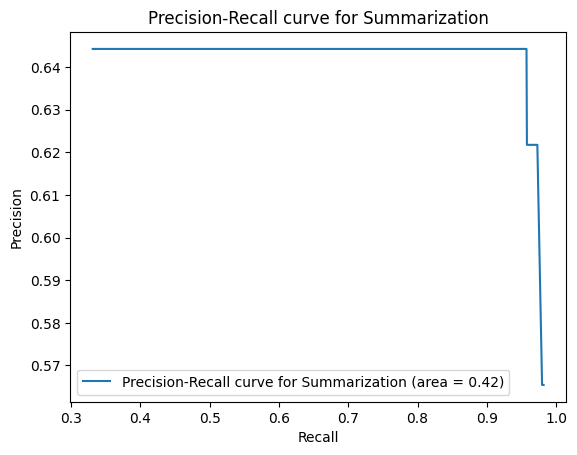


####### Time to process 200 documents: 
 
        - 1.7064077854156494 seconds 

        - 0.008532038927078246 seconds per document
        




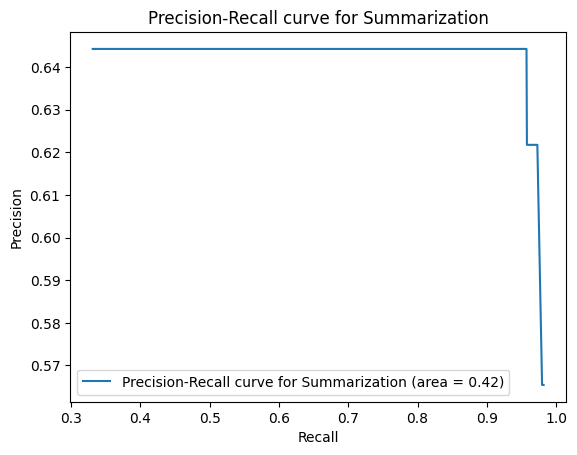


####### Time to process 200 documents: 
 
        - 1.1069104671478271 seconds 

        - 0.005534552335739136 seconds per document
        




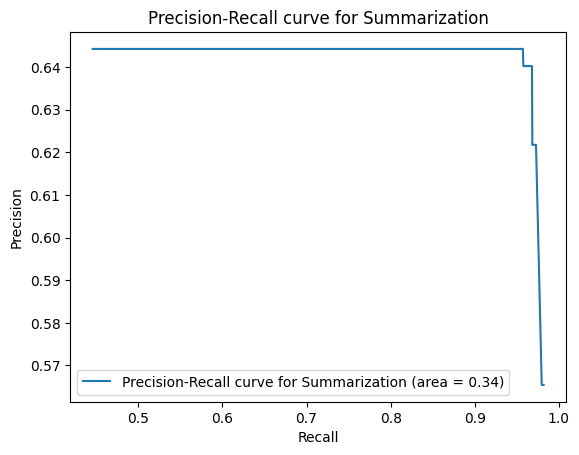


####### Time to process 200 documents: 
 
        - 1.1079201698303223 seconds 

        - 0.005539600849151611 seconds per document
        




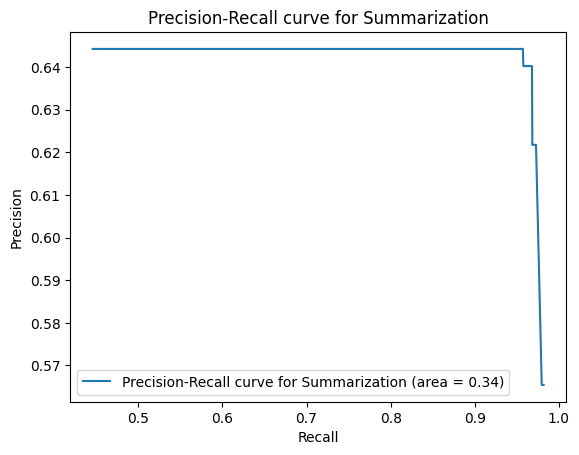


####### Time to process 200 documents: 
 
        - 1.1057627201080322 seconds 

        - 0.0055288136005401615 seconds per document
        




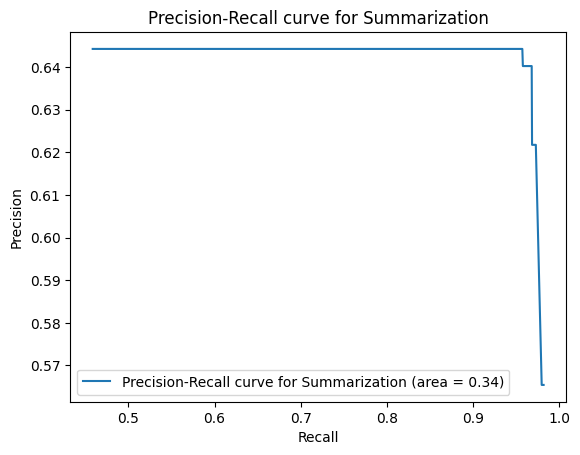


####### Time to process 200 documents: 
 
        - 1.1759274005889893 seconds 

        - 0.005879637002944946 seconds per document
        




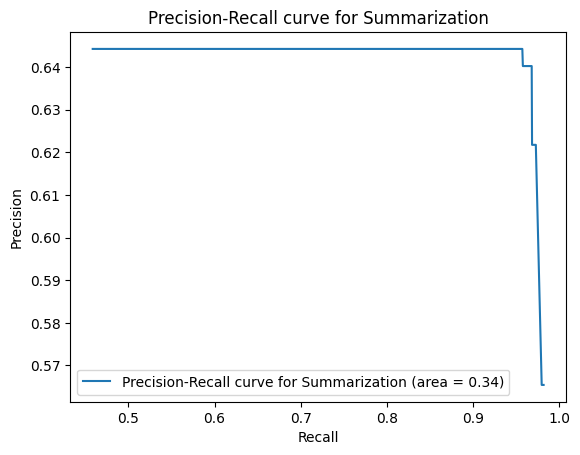


####### Time to process 200 documents: 
 
        - 1.646104335784912 seconds 

        - 0.00823052167892456 seconds per document
        




In [82]:
#code, statistics and/or charts here
max_clusters = [2,3,4,6,8,10]
number_of_sentences = [3,5,7,9,11,13]
metrics = ['cosine', 'euclidean']

results = []


docs_to_analize = documents[400:600]
real_summaries = summaries[400:600]
produced_summaries = []


for max_cluster in max_clusters:
    for n_sentences in number_of_sentences:
        for metric in metrics:
            for doc in docs_to_analize:
                clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=max_cluster, linkage="ward")
                summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=n_sentences)
                produced_summaries.append(summary)

            average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(produced_summaries, real_summaries, f"c: {max_cluster}, n: {n_sentences}, m: {metric}", plot_roc=False)
            results.append([max_cluster, n_sentences, metric, average_precision, average_recall, f1, std_precision, std_recall, m_a_p])
            produced_summaries = []

results_df = pd.DataFrame(results, columns=["max_clusters", "number_of_sentences", "metric", "average_precision", "average_recall", "f1", "std_precision", "std_recall", "m_a_p"])

In [88]:
#save results as csv
results_df.to_csv("comparison.csv", index=False)

In [91]:
results_df

,max_clusters,number_of_sentences,metric,average_precision,average_recall,f1,std_precision,std_recall,m_a_p
0,2,3,cosine,0.453504,0.449012,0.451247,0.110261,0.174275,0.646069
1,2,3,euclidean,0.453504,0.449012,0.451247,0.110261,0.174275,0.646069
2,2,5,cosine,0.457060,0.633170,0.530891,0.085369,0.192923,0.561392
3,2,5,euclidean,0.457060,0.633170,0.530891,0.085369,0.192923,0.561392
4,2,7,cosine,0.469898,0.768889,0.583312,0.070187,0.190128,0.492352
...,...,...,...,...,...,...,...,...,...
67,10,9,euclidean,0.484872,0.934921,0.638568,0.058787,0.064162,0.418472
68,10,11,cosine,0.486431,0.941682,0.641495,0.058766,0.047902,0.344811
69,10,11,euclidean,0.486431,0.941682,0.641495,0.058766,0.047902,0.344811
70,10,13,cosine,0.486635,0.943571,0.642110,0.058829,0.039310,0.336604


In [92]:
#get the best and worst map
best_map = results_df.loc[results_df["m_a_p"].idxmax()]
worst_map = resultsbest_map = results_df.loc[results_df["m_a_p"].idxmin()]

print(f"Best MAP: {best_map}")
print(f"Worst MAP: {worst_map}")

Best MAP: max_clusters                  2
number_of_sentences           3
metric                   cosine
average_precision      0.453504
average_recall         0.449012
f1                     0.451247
std_precision          0.110261
std_recall             0.174275
m_a_p                  0.646069
Name: 0, dtype: object
Worst MAP: max_clusters                 10
number_of_sentences          13
metric                   cosine
average_precision      0.486635
average_recall         0.943571
f1                      0.64211
std_precision          0.058829
std_recall              0.03931
m_a_p                  0.336604
Name: 70, dtype: object


**(3)** Are anchor sentences (capturing multiple topics) included? And less relevant outlier sen- tences excluded? Justify

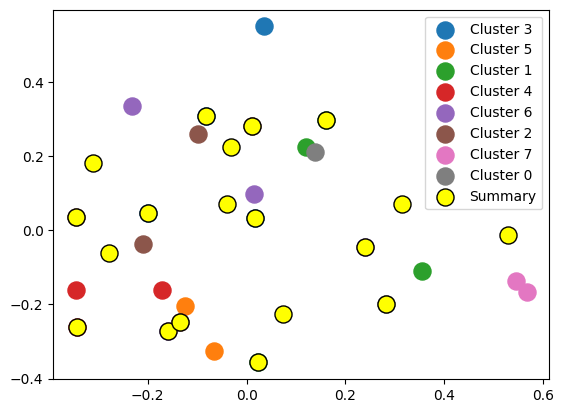

A conflict between the Argentine State and water firm Aguas Argentinas , controlled by France 's Suez , is casting doubt on the firm 's future . The firm agreed to invest 242m pesos . The government has rejected the 60 % rise and wants Aguas Argentinas to make an annual investment of 400m pesos ( $ 136m ; Â£72.3m ) in improvements . The firm , which serves the province of Buenos Aires , wants a tariff rise of 60 % to fund water-supply improvements .Mr De Vido said that the Argentine state would not make a contribution `` in the form of a subsidy '' . Planning Minister Julio De Vido has offered State help but not for `` free '' .The issue has attracted European interest . He has said a contribution could be made in return for a seat on the company 's board . In Argentina , Suez 's subsidiary , which has been fined for cutting the supply of water during a recent heat wave and allegedly failing to keep up investment to meet the demand for water , has maintained a tense relationship with t

In [134]:
doc = documents[500]

clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=10, linkage="complete")
summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=8)

#plot
plot_clusters(clusters, summary=summary)

print(summary)

We don't have a specific answer to this, since our metric to choose the sentece is based on the distance from the centroid

**(4)** Given a set of documents, plot the distribution of the number of keywords per document. 
Are keywords generally dissimilar? If not, how would you tackle this challenge?

### Part 2: Supervised IR

(**1**) Does the incorporation of relevance feedback from ideal extracts significantly impact the performance of the IR system? Hypothesize why is that so.



(**2**) Are the learned models able to generalize from one category to another? Justify.



(**3**) Which features appear to be more relevant to the target summarization task? Do sentence- location features aid summarization?



(**4**) In alternative to the given reference extracts, consider the presence of manual abstractive 
summaries, can supervised IR be used to explore such feedback? Justify

**...** (additional questions with empirical results)

<H3>END</H3>